In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Load Data
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)

# ใช้ข้อมูลจากแถวแรก (Snapshot 1 ชุด)
raw_text = str(df.iloc[0]['RAW_WAVEFORM'])

# 2. Parsing the RAW_WAVEFORM using GE Protocol
# ข้อมูลแต่ละบล็อกจะถูกคั่นด้วย =:VTw หรือ :VTw
blocks = raw_text.replace('=', '').split(':VTw')
# กรองเฉพาะบล็อกที่มีข้อมูลครบ 120 ตัวอักษร
blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]

pressure_hex = ""
flow_hex = ""
volume_hex = ""

for b in blocks:
    pressure_hex += b[0:30]
    flow_hex += b[30:60]
    volume_hex += b[60:90]

# GE Scaling Function
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0) # fallback
    return np.array(vals)

pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
raw_volume = ge_scaling(volume_hex, 512, 3584, 0, 2000)

time_step = 0.04
time_axis = np.arange(0, len(pressure) * time_step, time_step)

# --- Plot 1: Decoded Raw Signals ---
fig, ax = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
ax[0].plot(time_axis, pressure, color='#1f77b4', linewidth=1.5)
ax[0].set_ylabel('Pressure\n(cmH2O)', fontweight='bold')
ax[0].set_title('Step 1: Raw Signal Decoding via GE Protocol', fontsize=14, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].plot(time_axis, flow, color='#ff7f0e', linewidth=1.5)
ax[1].set_ylabel('Flow\n(L/min)', fontweight='bold')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].grid(True, linestyle='--', alpha=0.6)

ax[2].plot(time_axis, raw_volume, color='#2ca02c', linewidth=1.5)
ax[2].set_ylabel('Volume\n(ml)', fontweight='bold')
ax[2].set_xlabel('Time (seconds)', fontweight='bold')
ax[2].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('01_decoded_signals.png')
plt.close()

# 3. Breath Segmentation
def segment_breaths(flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end],
                'volume_segment': raw_volume[idx_start:idx_end],
            })
    return breaths

detected_breaths = segment_breaths(flow, time_axis)

# 4. Feature Extraction & Flow Integration
features = []
for b in detected_breaths:
    f = {}
    f['breath_id'] = b['breath_id']
    f['PIP'] = np.max(b['pressure_segment'])
    f['PEEP'] = np.min(b['pressure_segment'])
    f['Max_Flow'] = np.max(b['flow_segment'])
    f['Duration'] = b['duration']
    
    # Flow Integration
    insp_flow = b['flow_segment'][b['flow_segment'] > 0]
    calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
    f['Calculated_Vt_ml'] = calculated_vt
    
    # Original Volume Peak (for comparison)
    f['Raw_Volume_Peak'] = np.max(b['volume_segment']) - b['volume_segment'][0] if len(b['volume_segment'])>0 else 0
    
    features.append(f)

df_features = pd.DataFrame(features)

# 5. Isolation Forest (AI Anomaly Detection)
if len(df_features) > 1:
    X_ai = df_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    # Use contamination=0.2 roughly expecting 1-2 anomalies
    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    df_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
else:
    df_features['Anomaly_Status'] = 1 # Not enough data to cluster

print("=== Final AI Feature Matrix ===")
print(df_features[['breath_id', 'PIP', 'Max_Flow', 'Calculated_Vt_ml', 'Anomaly_Status']].to_string(index=False))

# --- Plot 2: AI Cluster Plot ---
if len(df_features) > 1:
    plt.figure(figsize=(10, 6))
    colors = ['red' if x == -1 else 'blue' for x in df_features['Anomaly_Status']]
    plt.scatter(df_features['PIP'], df_features['Calculated_Vt_ml'], c=colors, s=150, edgecolors='black', alpha=0.7)

    for i, txt in enumerate(df_features['breath_id']):
        label = "Anomaly" if df_features.iloc[i]['Anomaly_Status'] == -1 else "Normal"
        plt.annotate(f"B{txt} ({label})", 
                     (df_features.iloc[i]['PIP']+0.2, df_features.iloc[i]['Calculated_Vt_ml']), 
                     fontsize=11, fontweight='bold')

    plt.title('Step 4: AI Anomaly Detection (Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontweight='bold')
    plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('02_ai_clustering.png')
    plt.close()

=== Final AI Feature Matrix ===
 breath_id       PIP  Max_Flow  Calculated_Vt_ml  Anomaly_Status
         1 19.335938 79.296875        870.833333              -1
         2 19.335938 66.927083        765.321181               1
         3 19.335938 63.085938        515.581597               1


In [25]:
import numpy as np


raw_text = "=:VTw28328428428428227E2812822862BF7A979779279078F79779A7988219F720020020020020020020020020020C201201200201201201201201201201"
print("--- Step 1: Data Ingestion ---")
print(f"ข้อมูลดิบ (String): {raw_text[:50]}... (ความยาว {len(raw_text)} ตัวอักษร)\n")

# Step 2: Block Splitting (ตัดแบ่งข้อมูลด้วย :VTw)
# ลบเครื่องหมาย '=' และใช้ ':VTw' เป็นตัวตัดแบ่ง
blocks = raw_text.replace('=', '').split(':VTw')
# เลือกบล็อกที่มีข้อมูลครบ 120 ตัวอักษร (บล็อกแรกที่ใช้ได้)
valid_block = [b for b in blocks if len(b) >= 120][0]
print("--- Step 2: Block Splitting ---")
print(f"บล็อกที่ถูกตัดมา (120 ตัวอักษร): {valid_block}\n")

# Step 3: Sensor Separation (แยก 120 ตัวอักษร เป็น 4 ชุด)
pressure_str = valid_block[0:30]    # 30 ตัวแรก
flow_str = valid_block[30:60]       # 30 ตัวถัดมา
volume_str = valid_block[60:90]     # 30 ตัวถัดมา
agent_str = valid_block[90:120]     # 30 ตัวสุดท้าย

print("--- Step 3: Sensor Separation ---")
print(f"1. Pressure String : {pressure_str}")
print(f"2. Flow String     : {flow_str}")
print(f"3. Volume String   : {volume_str}")
print(f"4. Agent String    : {agent_str}\n")

# Step 4: Hex Chunking (หั่นย่อยชิ้นละ 3 ตัวอักษร)

# ตัวอย่างทำเฉพาะ Pressure ให้ดูเป็นไอเดีย
pressure_chunks = [pressure_str[i:i+3] for i in range(0, len(pressure_str), 3)]
print("--- Step 4: Hex Chunking (ตัวอย่างเซ็นเซอร์ Pressure) ---")
print(f"หั่นทีละ 3 ตัวอักษร (Hex): {pressure_chunks}\n")

# Step 5: Hex-to-Dec Conversion (แปลงฐาน 16 เป็นฐาน 10)
# ใช้คำสั่ง int(ค่า, 16) เพื่อแปลงเป็นตัวเลข
pressure_dec = [int(h, 16) for h in pressure_chunks]
print("--- Step 5: Hex-to-Dec Conversion ---")
print(f"แปลงเป็นเลขฐาน 10 (Decimal): {pressure_dec}\n")

# Step 6: Linear Scaling (เข้าสมการ GE Protocol)
# สูตร: RAW = (Scaled - Scaled_0) * (RAW_1 - RAW_0) / (Scaled_1 - Scaled_0) + RAW_0
# พารามิเตอร์ Pressure: Scaled_0=0, Scaled_1=3584, RAW_0=-20, RAW_1=120
scaled_0, scaled_1, raw_0, raw_1 = 0, 3584, -20, 120

pressure_scaled = []
for dec_val in pressure_dec:
    real_val = (dec_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
    pressure_scaled.append(round(real_val, 2)) # ปัดทศนิยม 2 ตำแหน่ง

print("--- Step 6: Linear Scaling ---")
print(f"แปลงเป็นค่าทางการแพทย์ (cmH2O): {pressure_scaled}\n")


# Step 7: Time Synchronization (ประกอบแกนเวลา)
# ข้อมูล 1 ค่า = 40 ms (0.04 วินาที)
time_step = 0.04
time_axis = [round(i * time_step, 2) for i in range(len(pressure_scaled))]

print("--- Step 7: Time Synchronization ---")
print(f"แกนเวลา (วินาที): {time_axis}\n")

# --- แสดงผลลัพธ์สุดท้ายประกอบกัน ---
print("=== FINAL OUTPUT (ตัวอย่าง 5 จุดแรกของ Pressure) ===")
for i in range(5):
    print(f"เวลา {time_axis[i]:.2f} วินาที | รหัสดิบ: {pressure_chunks[i]} -> ฐานสิบ: {pressure_dec[i]:3d} -> ความดันจริง: {pressure_scaled[i]:.2f} cmH2O")

--- Step 1: Data Ingestion ---
ข้อมูลดิบ (String): =:VTw28328428428428227E2812822862BF7A979779279078F... (ความยาว 125 ตัวอักษร)

--- Step 2: Block Splitting ---
บล็อกที่ถูกตัดมา (120 ตัวอักษร): 28328428428428227E2812822862BF7A979779279078F79779A7988219F720020020020020020020020020020C201201200201201201201201201201

--- Step 3: Sensor Separation ---
1. Pressure String : 28328428428428227E2812822862BF
2. Flow String     : 7A979779279078F79779A7988219F7
3. Volume String   : 20020020020020020020020020020C
4. Agent String    : 201201200201201201201201201201

--- Step 4: Hex Chunking (ตัวอย่างเซ็นเซอร์ Pressure) ---
หั่นทีละ 3 ตัวอักษร (Hex): ['283', '284', '284', '284', '282', '27E', '281', '282', '286', '2BF']

--- Step 5: Hex-to-Dec Conversion ---
แปลงเป็นเลขฐาน 10 (Decimal): [643, 644, 644, 644, 642, 638, 641, 642, 646, 703]

--- Step 6: Linear Scaling ---
แปลงเป็นค่าทางการแพทย์ (cmH2O): [5.12, 5.16, 5.16, 5.16, 5.08, 4.92, 5.04, 5.08, 5.23, 7.46]

--- Step 7: Time Synchronization ---
แกน

In [3]:
# Import Libraries & Load Data
# นำเข้าไลบรารีสำหรับจัดการข้อมูลตัวเลขและตาราง
import pandas as pd
import numpy as np

# นำเข้าไลบรารีสำหรับวาดกราฟ
import matplotlib.pyplot as plt

# นำเข้าโมเดล AI (Isolation Forest) สำหรับตรวจจับความผิดปกติ
from sklearn.ensemble import IsolationForest

# โหลดไฟล์ข้อมูลเซ็นเซอร์เครื่องช่วยหายใจ
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)

# เลือกข้อมูลแถวแรกสุดมาใช้งาน (หรือเปลี่ยน index ถ้าต้องการดูคนไข้เคสอื่น)
# เราจะดึงเฉพาะคอลัมน์ RAW_WAVEFORM ที่เป็นโค้ดฐาน 16 (Hexadecimal) ออกมา
raw_text = str(df.iloc[0]['RAW_WAVEFORM'])

print("โหลดข้อมูลสำเร็จ! ความยาวของข้อมูลดิบ:", len(raw_text), "ตัวอักษร")

โหลดข้อมูลสำเร็จ! ความยาวของข้อมูลดิบ: 3125 ตัวอักษร


In [4]:
# ลบเครื่องหมาย '=' ทิ้ง และใช้คำว่า ':VTw' เป็นจุดตัดแบ่งข้อมูลออกเป็นบล็อกๆ
blocks = raw_text.replace('=', '').split(':VTw')

# กรองเอาเฉพาะบล็อกที่มีความยาวครบ 120 ตัวอักษร (ตามมาตรฐาน 1 Cycle)
blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]

# สร้างตัวแปร String ว่างๆ ไว้เก็บโค้ด Hex ของแต่ละเซ็นเซอร์
pressure_hex = ""
flow_hex = ""
volume_hex = ""

# วนลูปนำข้อมูลแต่ละบล็อกมาต่อกันให้เป็นสายยาวๆ
# อ้างอิงตาม GE Protocol: 30 ตัวแรกคือ Pressure, 30 ตัวถัดมาคือ Flow, 30 ตัวถัดมาคือ Volume
for b in blocks:
    pressure_hex += b[0:30]
    flow_hex += b[30:60]
    volume_hex += b[60:90]

print(f"เตรียมข้อมูล Hex สำเร็จ: ได้ข้อมูลทั้งหมด {len(pressure_hex)//3} จุด (Data Points)")

เตรียมข้อมูล Hex สำเร็จ: ได้ข้อมูลทั้งหมด 250 จุด (Data Points)


In [5]:

# GE Protocol Decoding & Time Axis

# สร้างฟังก์ชันสำหรับแปลงโค้ด Hex เป็นตัวเลข (อ้างอิงสมการ Linear Scaling จากคู่มือ GE)
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    # สับ String ยาวๆ ออกเป็นชิ้นละ 3 ตัวอักษร
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    
    for h in chunks:
        try:
            # 1. แปลงเลขฐาน 16 (Hex) เป็นฐาน 10 (Decimal)
            s_val = int(h, 16)
            # 2. เข้าสมการเทียบบัญญัติไตรยางศ์ (Linear Interpolation)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0) # กรณีมีอักขระแปลกปลอม ให้ใส่ 0 ป้องกัน error
            
    return np.array(vals)

# เรียกใช้ฟังก์ชันแปลงค่า (ใส่ค่าพารามิเตอร์ตามคู่มือของแต่ละเซ็นเซอร์)
pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
raw_volume = ge_scaling(volume_hex, 512, 3584, 0, 2000)

# สร้างแกนเวลา (Time Axis) โดยอิงตาม Sampling Rate = 40 ms (0.04 วินาที) ต่อ 1 ค่า
time_step = 0.04
time_axis = np.arange(0, len(pressure) * time_step, time_step)

print("ถอดรหัสสัญญาณเสร็จสิ้น! ตอนนี้ได้ตัวเลขทางการแพทย์ที่นำไปพล็อตกราฟได้แล้ว")

ถอดรหัสสัญญาณเสร็จสิ้น! ตอนนี้ได้ตัวเลขทางการแพทย์ที่นำไปพล็อตกราฟได้แล้ว


In [6]:
# Breath Segmentation (Zero-Crossing)


def segment_breaths(flow_signal, time_signal):
    # ทำ Moving Average แบบง่ายๆ เพื่อลด Noise ของสัญญาณแกว่ง (Smooth signal)
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    
    inspiratory_starts = []
    threshold = 2.0 # กำหนดว่า Flow ต้องขึ้นไปเกิน 2 L/min ถึงจะนับว่าพยายามหายใจเข้าจริงๆ
    
    # วนลูปหาจุดที่ Flow วิ่งจากติดลบไปเป็นบวก (จุดเริ่มต้นการหายใจเข้า)
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            # เช็คยืนยันไปข้างหน้าอีก 5 จุดว่าค่าพุ่งขึ้นจริง ไม่ใช่แค่สไปค์ (Spike) ของสัญญาณ
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    
    # วนลูปนำจุดเริ่มต้น มาจับคู่กันเพื่อหั่นกราฟออกเป็นท่อนๆ
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        
        # คัดกรอง Noise: ลมหายใจ 1 รอบต้องใช้เวลาเกิน 0.5 วินาที
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end],
                'volume_segment': raw_volume[idx_start:idx_end],
            })
    return breaths

# เรียกใช้ฟังก์ชันตัดแบ่งลมหายใจ
detected_breaths = segment_breaths(flow, time_axis)
print(f"ตัดแบ่งลมหายใจอัตโนมัติสำเร็จ! พบลมหายใจทั้งหมด {len(detected_breaths)} ครั้ง")

ตัดแบ่งลมหายใจอัตโนมัติสำเร็จ! พบลมหายใจทั้งหมด 3 ครั้ง


In [7]:

# Feature Extraction & Flow Integration


features = []

# วนลูปเข้าไปในลมหายใจแต่ละครั้งที่ตัดมาได้
for b in detected_breaths:
    f = {}
    f['breath_id'] = b['breath_id']
    f['PIP'] = np.max(b['pressure_segment']) # หาค่าความดันสูงสุด (Peak Inspiratory Pressure)
    f['PEEP'] = np.min(b['pressure_segment']) # หาค่าความดันต่ำสุดตอนหายใจออก
    f['Max_Flow'] = np.max(b['flow_segment']) # หาอัตราการไหลสูงสุด
    f['Duration'] = b['duration'] # ระยะเวลาหายใจ 1 รอบ
    
    # 🌟 ท่าไม้ตาย (Flow Integration) 🌟
    # คัดเฉพาะช่วงที่หายใจเข้า (Flow เป็นบวก)
    insp_flow = b['flow_segment'][b['flow_segment'] > 0]
    
    # คำนวณพื้นที่ใต้กราฟ: (Flow ลิตร/นาที) / 60 วินาที * (0.04 วินาที) * 1000 (แปลงเป็น ml)
    calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
    f['Calculated_Vt_ml'] = calculated_vt
    
    features.append(f)

# แปลงผลลัพธ์ให้อยู่ในรูปแบบตาราง (DataFrame)
df_features = pd.DataFrame(features)
print("สกัดฟีเจอร์และคำนวณ Volume ใหม่สำเร็จ!")
print(df_features[['breath_id', 'PIP', 'Max_Flow', 'Calculated_Vt_ml']])

สกัดฟีเจอร์และคำนวณ Volume ใหม่สำเร็จ!
   breath_id        PIP   Max_Flow  Calculated_Vt_ml
0          1  19.335938  79.296875        870.833333
1          2  19.335938  66.927083        765.321181
2          3  19.335938  63.085938        515.581597


In [8]:
#AI Anomaly Detection (Isolation Forest)

# เช็คก่อนว่ามีลมหายใจมากพอให้ AI จัดกลุ่มหรือไม่ (ต้องมี > 1 ครั้ง)
if len(df_features) > 1:
    # เลือกตัวแปร (Features) ที่จะให้ AI เรียนรู้
    X_ai = df_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    
    # สร้างโมเดล Isolation Forest
    # contamination=0.2 หมายถึง เราคาดเดาว่าอาจจะมีความผิดปกติปะปนอยู่ประมาณ 20%
    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    
    # สั่งให้ AI เรียนรู้และตัดสินใจเลย (Fit and Predict)
    # ผลลัพธ์: 1 = ปกติ (Normal), -1 = ผิดปกติ (Anomaly)
    df_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
else:
    # ถ้ามีลมหายใจแค่ 1 ครั้ง AI จะเปรียบเทียบไม่ได้ ให้ตีเป็นปกติไปก่อน
    df_features['Anomaly_Status'] = 1 

print("\n=== ผลลัพธ์การประเมินจากสมองกล AI ===")
print(df_features[['breath_id', 'PIP', 'Calculated_Vt_ml', 'Anomaly_Status']].to_string(index=False))


=== ผลลัพธ์การประเมินจากสมองกล AI ===
 breath_id       PIP  Calculated_Vt_ml  Anomaly_Status
         1 19.335938        870.833333              -1
         2 19.335938        765.321181               1
         3 19.335938        515.581597               1


จำนวน Snapshot ทั้งหมดในไฟล์: 1272 แถว

ประมวลผลเสร็จสิ้น 1233 แถว
สกัดลมหายใจ (Breath Cycles) ได้ทั้งหมดรวม: 2220 ครั้ง

=== สรุปผลการตรวจจับจาก AI ===
ลมหายใจปกติ (Normal): 2109 ครั้ง
ลมหายใจผิดปกติ/ต้านเครื่อง (Anomaly): 111 ครั้ง

[ตัวอย่างข้อมูลที่ AI มองว่าผิดปกติ]
       AdmissionID  R_ID  Breath_No        PIP  Calculated_Vt_ml
7    1707156033287  1049          1  19.375000        922.612847
14   1707221031263  1053          1   5.546875          7.291667
52   1705159935406  1073          5  20.312500         22.092014
93   1707451835911  1094          2  20.351562         29.991319
100  1707451835911  1097          3  20.351562         32.204861


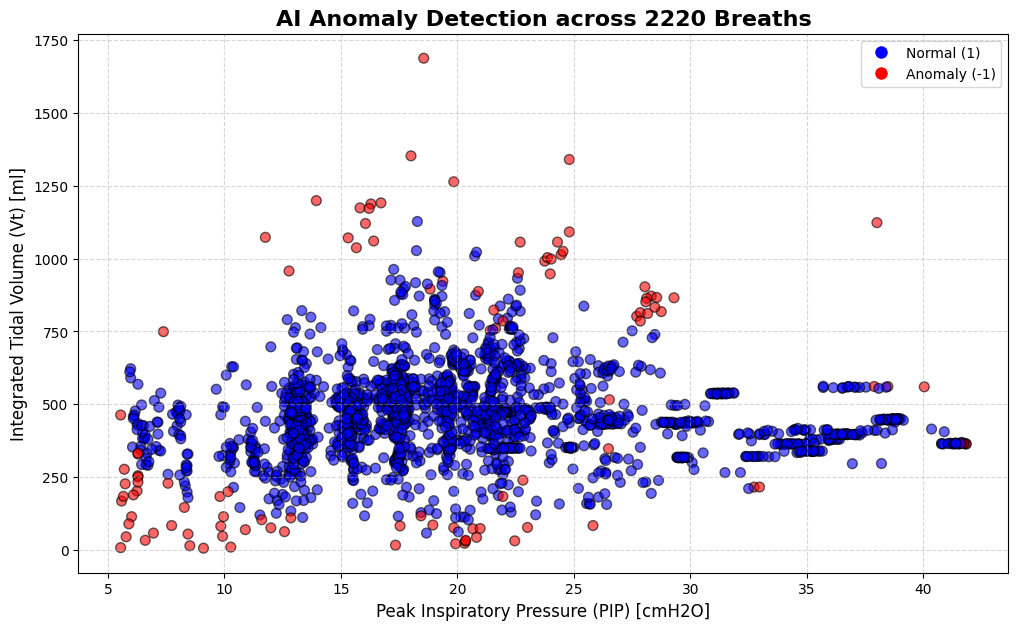

In [9]:

# FULL BATCH PROCESSING PIPELINE (รันทุกข้อมูล)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. โหลดข้อมูลทั้งหมดจากไฟล์ CSV
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)
print(f"จำนวน Snapshot ทั้งหมดในไฟล์: {len(df)} แถว")

# ------------------------------------------
# ฟังก์ชันมาตรฐาน (กำหนดไว้ใช้งานในลูป)
# ------------------------------------------
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end]
            })
    return breaths

# ------------------------------------------
# 2. เริ่มลูปดึงข้อมูลทุกแถว (Batch Processing)
# ------------------------------------------
all_features = [] # ลิสต์สำหรับเก็บลมหายใจของ 'ทุกคน' รวมกัน
total_processed_rows = 0

for index, row in df.iterrows():
    # ดึงข้อมูลที่จำเป็นของแต่ละแถว
    raw_text = str(row['RAW_WAVEFORM'])
    r_id = row['R_ID']
    admission_id = row['AdmissionID']
    
    # ข้ามแถวที่ไม่มีข้อมูล RAW_WAVEFORM
    if pd.isna(raw_text) or raw_text == 'nan':
        continue
        
    # หั่นบล็อกข้อมูล
    blocks = raw_text.replace('=', '').split(':VTw')
    blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]
    
    if not blocks:
        continue
        
    pressure_hex, flow_hex, volume_hex = "", "", ""
    for b in blocks:
        pressure_hex += b[0:30]
        flow_hex += b[30:60]
        volume_hex += b[60:90]

    # ถอดรหัส (Decoding)
    pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
    flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
    
    time_step = 0.04
    time_axis = np.arange(0, len(pressure) * time_step, time_step)

    # ตัดแบ่งลมหายใจ (Segmentation)
    detected_breaths = segment_breaths(flow, time_axis)
    
    # สกัด Feature & Flow Integration ของแถวนี้
    for b in detected_breaths:
        insp_flow = b['flow_segment'][b['flow_segment'] > 0]
        calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # เก็บข้อมูลลงในคลังกลาง (มี R_ID และ AdmissionID กำกับเพื่อระบุตัวคนไข้)
        all_features.append({
            'R_ID': r_id,
            'AdmissionID': admission_id,
            'Breath_No': b['breath_id'],
            'PIP': np.max(b['pressure_segment']),
            'Max_Flow': np.max(b['flow_segment']),
            'Duration': b['duration'],
            'Calculated_Vt_ml': calculated_vt
        })
    
    total_processed_rows += 1

# แปลงเป็น DataFrame เพื่อส่งให้ AI
df_all_features = pd.DataFrame(all_features)
print(f"\nประมวลผลเสร็จสิ้น {total_processed_rows} แถว")
print(f"สกัดลมหายใจ (Breath Cycles) ได้ทั้งหมดรวม: {len(df_all_features)} ครั้ง")

# ------------------------------------------
# 3. AI Anomaly Detection (รันทีเดียวบนข้อมูลทั้งหมด)
# ------------------------------------------
if len(df_all_features) > 1:
    # เลือกตัวแปรให้ AI เรียนรู้
    X_ai = df_all_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    
    # กำหนด Contamination (คาดว่ามี Asynchrony เกิดขึ้นกี่เปอร์เซ็นต์ เช่น 5% หรือ 0.05)
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    
    # หาความผิดปกติ
    df_all_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
    
    # นับจำนวนลมหายใจปกติและผิดปกติ
    anomalies = df_all_features[df_all_features['Anomaly_Status'] == -1]
    normal = df_all_features[df_all_features['Anomaly_Status'] == 1]
    
    print(f"\n=== สรุปผลการตรวจจับจาก AI ===")
    print(f"ลมหายใจปกติ (Normal): {len(normal)} ครั้ง")
    print(f"ลมหายใจผิดปกติ/ต้านเครื่อง (Anomaly): {len(anomalies)} ครั้ง")
    
    # แสดงตัวอย่างลมหายใจที่ผิดปกติ (โชว์ว่ามาจากคนไข้ ID ไหนบ้าง)
    print("\n[ตัวอย่างข้อมูลที่ AI มองว่าผิดปกติ]")
    print(anomalies[['AdmissionID', 'R_ID', 'Breath_No', 'PIP', 'Calculated_Vt_ml']].head())
    
    # พล็อตกราฟจุด (Scatter Plot) ของข้อมูลทั้งหมด
    plt.figure(figsize=(12, 7))
    colors = ['red' if x == -1 else 'blue' for x in df_all_features['Anomaly_Status']]
    plt.scatter(df_all_features['PIP'], df_all_features['Calculated_Vt_ml'], c=colors, s=50, alpha=0.6, edgecolors='black')
    
    plt.title(f'AI Anomaly Detection across {len(df_all_features)} Breaths', fontsize=16, fontweight='bold')
    plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=12)
    plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # สร้าง Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal (1)', markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Anomaly (-1)', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()
else:
    print("พบข้อมูลน้อยเกินไป ไม่สามารถรันโมเดล AI ได้")

จำนวน Snapshot ทั้งหมดในไฟล์: 1272 แถว

ประมวลผลเสร็จสิ้น 1233 แถว
สกัดลมหายใจ (Breath Cycles) ได้ทั้งหมดรวม: 2220 ครั้ง

=== สรุปผลการตรวจจับจาก AI ===
ลมหายใจปกติ (Normal): 1998 ครั้ง
ลมหายใจผิดปกติ/ต้านเครื่อง (Anomaly): 222 ครั้ง

[ตัวอย่างข้อมูลที่ AI มองว่าผิดปกติ]
      AdmissionID  R_ID  Breath_No        PIP  Calculated_Vt_ml
3   1707156033287  1047          1  19.023438        860.677083
7   1707156033287  1049          1  19.375000        922.612847
9   1707156033287  1050          2  19.023438        841.536458
14  1707221031263  1053          1   5.546875          7.291667
52  1705159935406  1073          5  20.312500         22.092014


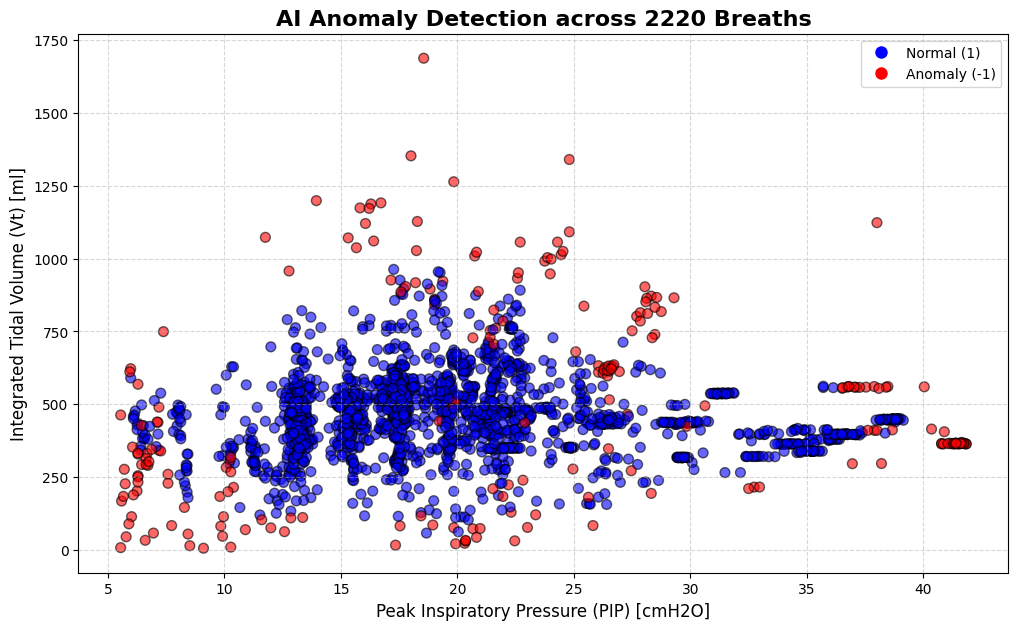

In [31]:

# FULL BATCH PROCESSING PIPELINE (รันทุกข้อมูล)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. โหลดข้อมูลทั้งหมดจากไฟล์ CSV
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)
print(f"จำนวน Snapshot ทั้งหมดในไฟล์: {len(df)} แถว")

# ------------------------------------------
# ฟังก์ชันมาตรฐาน (กำหนดไว้ใช้งานในลูป)
# ------------------------------------------
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end]
            })
    return breaths

# ------------------------------------------
# 2. เริ่มลูปดึงข้อมูลทุกแถว (Batch Processing)
# ------------------------------------------
all_features = [] # ลิสต์สำหรับเก็บลมหายใจของ 'ทุกคน' รวมกัน
total_processed_rows = 0

for index, row in df.iterrows():
    # ดึงข้อมูลที่จำเป็นของแต่ละแถว
    raw_text = str(row['RAW_WAVEFORM'])
    r_id = row['R_ID']
    admission_id = row['AdmissionID']
    
    # ข้ามแถวที่ไม่มีข้อมูล RAW_WAVEFORM
    if pd.isna(raw_text) or raw_text == 'nan':
        continue
        
    # หั่นบล็อกข้อมูล
    blocks = raw_text.replace('=', '').split(':VTw')
    blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]
    
    if not blocks:
        continue
        
    pressure_hex, flow_hex, volume_hex = "", "", ""
    for b in blocks:
        pressure_hex += b[0:30]
        flow_hex += b[30:60]
        volume_hex += b[60:90]

    # ถอดรหัส (Decoding)
    pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
    flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
    
    time_step = 0.04
    time_axis = np.arange(0, len(pressure) * time_step, time_step)

    # ตัดแบ่งลมหายใจ (Segmentation)
    detected_breaths = segment_breaths(flow, time_axis)
    
    # สกัด Feature & Flow Integration ของแถวนี้
    for b in detected_breaths:
        insp_flow = b['flow_segment'][b['flow_segment'] > 0]
        calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # เก็บข้อมูลลงในคลังกลาง (มี R_ID และ AdmissionID กำกับเพื่อระบุตัวคนไข้)
        all_features.append({
            'R_ID': r_id,
            'AdmissionID': admission_id,
            'Breath_No': b['breath_id'],
            'PIP': np.max(b['pressure_segment']),
            'Max_Flow': np.max(b['flow_segment']),
            'Duration': b['duration'],
            'Calculated_Vt_ml': calculated_vt
        })
    
    total_processed_rows += 1

# แปลงเป็น DataFrame เพื่อส่งให้ AI
df_all_features = pd.DataFrame(all_features)
print(f"\nประมวลผลเสร็จสิ้น {total_processed_rows} แถว")
print(f"สกัดลมหายใจ (Breath Cycles) ได้ทั้งหมดรวม: {len(df_all_features)} ครั้ง")

# ------------------------------------------
# 3. AI Anomaly Detection (รันทีเดียวบนข้อมูลทั้งหมด)
# ------------------------------------------
if len(df_all_features) > 1:
    # เลือกตัวแปรให้ AI เรียนรู้
    X_ai = df_all_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    
    # กำหนด Contamination (คาดว่ามี Asynchrony เกิดขึ้นกี่เปอร์เซ็นต์ เช่น 5% หรือ 0.05)
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    
    # หาความผิดปกติ
    df_all_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
    
    # นับจำนวนลมหายใจปกติและผิดปกติ
    anomalies = df_all_features[df_all_features['Anomaly_Status'] == -1]
    normal = df_all_features[df_all_features['Anomaly_Status'] == 1]
    
    print(f"\n=== สรุปผลการตรวจจับจาก AI ===")
    print(f"ลมหายใจปกติ (Normal): {len(normal)} ครั้ง")
    print(f"ลมหายใจผิดปกติ/ต้านเครื่อง (Anomaly): {len(anomalies)} ครั้ง")
    
    # แสดงตัวอย่างลมหายใจที่ผิดปกติ (โชว์ว่ามาจากคนไข้ ID ไหนบ้าง)
    print("\n[ตัวอย่างข้อมูลที่ AI มองว่าผิดปกติ]")
    print(anomalies[['AdmissionID', 'R_ID', 'Breath_No', 'PIP', 'Calculated_Vt_ml']].head())
    
    # พล็อตกราฟจุด (Scatter Plot) ของข้อมูลทั้งหมด
    plt.figure(figsize=(12, 7))
    colors = ['red' if x == -1 else 'blue' for x in df_all_features['Anomaly_Status']]
    plt.scatter(df_all_features['PIP'], df_all_features['Calculated_Vt_ml'], c=colors, s=50, alpha=0.6, edgecolors='black')
    
    plt.title(f'AI Anomaly Detection across {len(df_all_features)} Breaths', fontsize=16, fontweight='bold')
    plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=12)
    plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # สร้าง Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal (1)', markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Anomaly (-1)', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()
else:
    print("พบข้อมูลน้อยเกินไป ไม่สามารถรันโมเดล AI ได้")

In [10]:
print(anomalies[['AdmissionID', 'R_ID', 'Breath_No', 'PIP', 'Calculated_Vt_ml']])

        AdmissionID  R_ID  Breath_No        PIP  Calculated_Vt_ml
7     1707156033287  1049          1  19.375000        922.612847
14    1707221031263  1053          1   5.546875          7.291667
52    1705159935406  1073          5  20.312500         22.092014
93    1707451835911  1094          2  20.351562         29.991319
100   1707451835911  1097          3  20.351562         32.204861
...             ...   ...        ...        ...               ...
2214  1770197347350  2314          1  24.453125       1013.498264
2215  1770197347350  2314          2  24.296875       1056.987847
2217  1770197347350  2316          1  24.531250       1025.173611
2218  1770197347350  2316          2  24.804688       1092.100694
2219  1770197347350  2317          1  24.023438        998.437500

[111 rows x 5 columns]


#Clinical Sub-typing

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [33]:
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path).dropna(subset=['RAW_WAVEFORM'])


# 1. PREPROCESSING & SIGNAL RECONSTRUCTION
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths_advanced(pressure_signal, flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        
        if duration > 0.5:
            # หาจุดที่เปลี่ยนจากหายใจเข้าเป็นหายใจออก (Flow ตัดศูนย์กลับลงมา)
            insp_flow_segment = flow_signal[idx_start:idx_end]
            # หา index ที่ flow ต่ำกว่า 0 ครั้งแรกหลังจากเริ่มหายใจ
            zero_crossings = np.where(insp_flow_segment < 0)[0]
            if len(zero_crossings) > 0:
                insp_end_idx = idx_start + zero_crossings[0]
            else:
                insp_end_idx = idx_end # fallback
                
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'insp_end_idx': insp_end_idx,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure_signal[idx_start:idx_end],
                'flow_segment': flow_signal[idx_start:idx_end]
            })
    return breaths

all_features = []
raw_waveforms_dl = [] # สำหรับ Deep Learning

time_step = 0.04
for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]
        f_hex += b[30:60]

    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)

    breaths = segment_breaths_advanced(pressure, flow, time_axis)
    
    for b in breaths:
        
        # ทิศทางที่ 3: Advanced Morphological Features
        
        insp_flow = flow[b['start_idx']:b['insp_end_idx']]
        exp_flow = flow[b['insp_end_idx']:b['end_idx']]
        
        # 1. Calculated Vt (Flow Integration)
        vt_ml = np.sum(insp_flow[insp_flow > 0]) / 60 * time_step * 1000
        
        # 2. Duty Cycle (Ti/Ttot)
        t_insp = (b['insp_end_idx'] - b['start_idx']) * time_step
        t_tot = b['duration']
        duty_cycle = t_insp / t_tot if t_tot > 0 else 0
        
        # 3. Work of Breathing (WOB) Approximate: Sum(Pressure * Flow * dt)
        insp_pressure = pressure[b['start_idx']:b['insp_end_idx']]
        # แปลง Flow L/min -> L/s
        wob_approx = np.sum(insp_pressure * (insp_flow/60) * time_step) 
        
        all_features.append({
            'AdmissionID': row['AdmissionID'],
            'R_ID': row['R_ID'],
            'PIP': np.max(b['pressure_segment']),
            'Max_Flow': np.max(b['flow_segment']),
            'Calculated_Vt_ml': vt_ml,
            'Duty_Cycle': duty_cycle,
            'WOB_Approx': wob_approx
        })
        
        # เก็บกราฟ Flow ความยาวคงที่ 60 จุด (2.4 วินาที) สำหรับ Deep Learning
        f_seg = b['flow_segment']
        if len(f_seg) >= 60:
            raw_waveforms_dl.append(f_seg[:60])
        else:
            raw_waveforms_dl.append(np.pad(f_seg, (0, 60 - len(f_seg)), 'constant'))

df_feat = pd.DataFrame(all_features)
print(f"สกัดฟีเจอร์สำเร็จ {len(df_feat)} ลมหายใจ")


สกัดฟีเจอร์สำเร็จ 2220 ลมหายใจ


In [ ]:
#k-mean 0.05

In [ ]:
#k-mean 0.1
# BASELINE: หา Anomalies ก่อน (Isolation Forest)
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml', 'Duty_Cycle', 'WOB_Approx']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(contamination=0.1, random_state=42) # คาดว่ามีผิดปกติ 10%
df_feat['Anomaly'] = iso.fit_predict(X_scaled)

# ทิศทางที่ 1: Clinical Sub-typing (K-Means บน Anomalies)
anomalies_df = df_feat[df_feat['Anomaly'] == -1].copy()

if len(anomalies_df) >= 3:
    kmeans = KMeans(n_clusters=3, random_state=42)
    anomalies_df['Sub_Type'] = kmeans.fit_predict(scaler.transform(anomalies_df[['PIP', 'Max_Flow', 'Calculated_Vt_ml', 'Duty_Cycle', 'WOB_Approx']]))
    
    # พยายาม Label ชื่อกลุ่มตามพฤติกรรม
    cluster_means = anomalies_df.groupby('Sub_Type')[['PIP', 'Calculated_Vt_ml']].mean()
    print("\n--- ทิศทางที่ 1: Clinical Sub-typing (จัดกลุ่มความผิดปกติ) ---")
    print(cluster_means)
else:
    print("ไม่พบความผิดปกติมากพอให้จัดกลุ่ม")

# ทิศทางที่ 2: Patient-Level Asynchrony Index (AI%) Dashboard
# จัดกลุ่มตามคนไข้ (AdmissionID)
patient_dash = df_feat.groupby('AdmissionID').agg(
    Total_Breaths=('Anomaly', 'count'),
    Anomalies=('Anomaly', lambda x: (x == -1).sum())
).reset_index()

patient_dash['Asynchrony_Index_%'] = (patient_dash['Anomalies'] / patient_dash['Total_Breaths']) * 100
patient_dash['Risk_Level'] = pd.cut(patient_dash['Asynchrony_Index_%'], 
                                    bins=[-1, 5, 10, 100], 
                                    labels=['Low', 'Medium', 'High (Critical)'])

print("\n--- ทิศทางที่ 2: Patient Risk Dashboard (ดัชนีชี้วัดรายผู้ป่วย) ---")
print(patient_dash.sort_values('Asynchrony_Index_%', ascending=False).head(5).to_string(index=False))


--- ทิศทางที่ 1: Clinical Sub-typing (จัดกลุ่มความผิดปกติ) ---
                PIP  Calculated_Vt_ml
Sub_Type                             
0         21.651901        659.867644
1         10.276563        202.271991
2         38.747656        410.157118

--- ทิศทางที่ 2: Patient Risk Dashboard (ดัชนีชี้วัดรายผู้ป่วย) ---
  AdmissionID  Total_Breaths  Anomalies  Asynchrony_Index_%      Risk_Level
1759827791265              2          2          100.000000 High (Critical)
1715146790599             13          9           69.230769 High (Critical)
1770197347350              9          6           66.666667 High (Critical)
1766410635141             15          8           53.333333 High (Critical)
1765302327954              2          1           50.000000 High (Critical)



--- ทิศทางที่ 4: Deep Learning Autoencoder ---
เทรน Deep Learning (Autoencoder) สำเร็จ!
Top 3 ลมหายใจที่ Deep Learning มองว่าหน้าตาแปลกที่สุด (Error สูงสุด):
       AdmissionID  Calculated_Vt_ml  DL_Reconstruction_Error
279  1715146790599       1056.814236                 2.313962
328  1721636531089        988.151042                 2.078920
728  1762268855969        687.717014                 1.809184


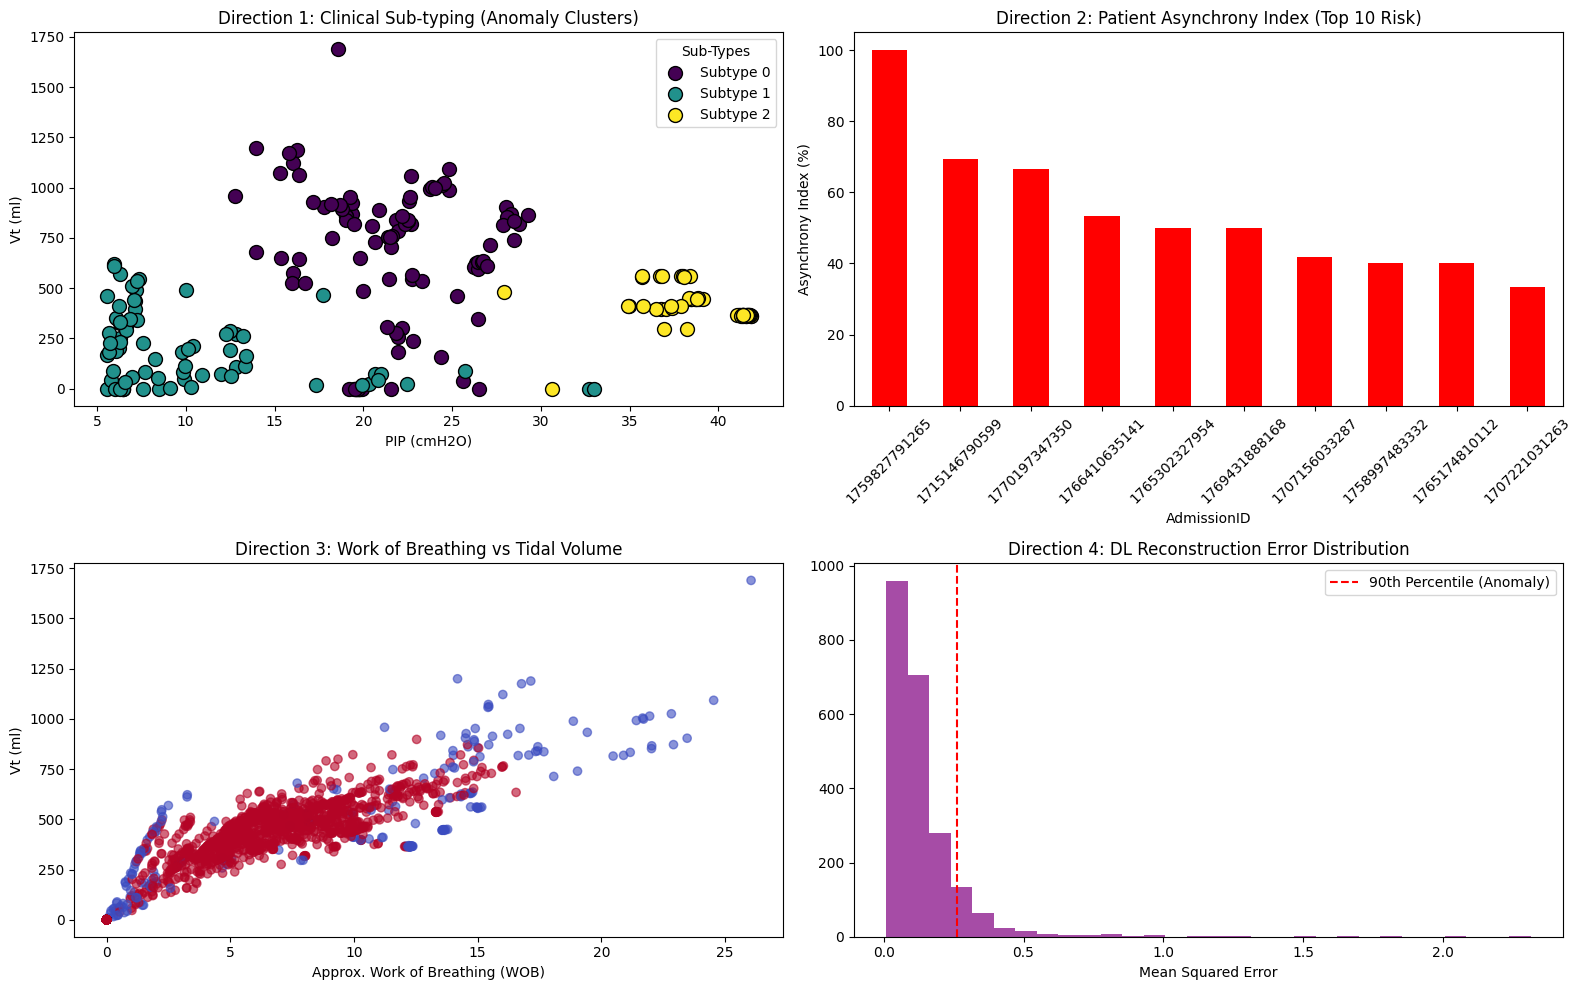

In [ ]:
# 4: Deep Learning (Autoencoder)
print("\n--- ทิศทางที่ 4: Deep Learning Autoencoder ---")
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Input
    
    # 1. เตรียมข้อมูล Train
    X_dl = np.array(raw_waveforms_dl)
    X_dl_scaled = StandardScaler().fit_transform(X_dl)
    
    # 2. สร้างโครงสร้าง Autoencoder อย่างง่าย (1D)
    model = Sequential([
        Input(shape=(60,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'), # คอขวด (Bottleneck)
        Dense(32, activation='relu'),
        Dense(60, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # 3. Train โมเดล (ให้เรียนรู้กราฟ Flow 60 จุด)
    # ในความเป็นจริงควร train เฉพาะข้อมูลปกติ แต่เพื่อโชว์ Concept เราจะเทรนทั้งหมดสั้นๆ
    model.fit(X_dl_scaled, X_dl_scaled, epochs=5, batch_size=16, verbose=0)
    
    # 4. ค้นหาความผิดปกติจาก Reconstruction Error
    X_pred = model.predict(X_dl_scaled, verbose=0)
    mse = np.mean(np.power(X_dl_scaled - X_pred, 2), axis=1)
    df_feat['DL_Reconstruction_Error'] = mse
    
    print("เทรน Deep Learning (Autoencoder) สำเร็จ!")
    print(f"Top 3 ลมหายใจที่ Deep Learning มองว่าหน้าตาแปลกที่สุด (Error สูงสุด):")
    print(df_feat.sort_values('DL_Reconstruction_Error', ascending=False)[['AdmissionID', 'Calculated_Vt_ml', 'DL_Reconstruction_Error']].head(3))
except Exception as e:
    print("ไม่สามารถรัน Deep Learning ได้ใน Environment นี้:", e)

# Plot สรุป Dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Sub-typing
# Plot each subtype separately so we can show a clear legend
if 'anomalies_df' in globals() and not anomalies_df.empty:
    cmap = plt.cm.viridis
    subtypes_sorted = sorted(anomalies_df['Sub_Type'].unique())
    for i, st in enumerate(subtypes_sorted):
        sub_df = anomalies_df[anomalies_df['Sub_Type'] == st]
        color = cmap(i / max(1, len(subtypes_sorted) - 1))
        axes[0,0].scatter(sub_df['PIP'], sub_df['Calculated_Vt_ml'], color=[color], label=f"Subtype {st}", s=100, edgecolors='black')
    axes[0,0].set_title('Clinical Sub-typing (Anomaly Clusters)')
    axes[0,0].set_xlabel('PIP (cmH2O)')
    axes[0,0].set_ylabel('Vt (ml)')
    axes[0,0].legend(title='Sub-Types')
else:
    axes[0,0].text(0.5, 0.5, 'Not enough anomalies to show sub-typing', ha='center', va='center')
    axes[0,0].set_axis_off()

# Plot 2: Patient AI%
patient_dash.sort_values('Asynchrony_Index_%', ascending=False).head(10).plot(
    kind='bar', x='AdmissionID', y='Asynchrony_Index_%', color='red', ax=axes[0,1], legend=False)
axes[0,1].set_title('Patient Asynchrony Index (Top 10 Risk)')
axes[0,1].set_ylabel('Asynchrony Index (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Advanced Feature (WOB vs Vt)
axes[1,0].scatter(df_feat['WOB_Approx'], df_feat['Calculated_Vt_ml'], c=df_feat['Anomaly'], cmap='coolwarm', alpha=0.6)
axes[1,0].set_title('Work of Breathing vs Tidal Volume')
axes[1,0].set_xlabel('Approx. Work of Breathing (WOB)')
axes[1,0].set_ylabel('Vt (ml)')

# Plot 4: DL Error distribution
axes[1,1].hist(df_feat['DL_Reconstruction_Error'], bins=30, color='purple', alpha=0.7)
axes[1,1].set_title(' DL Reconstruction Error Distribution')
axes[1,1].set_xlabel('Mean Squared Error')
axes[1,1].axvline(np.percentile(df_feat['DL_Reconstruction_Error'], 90), color='red', linestyle='dashed', label='90th Percentile (Anomaly)')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('phd_advanced_insights.png')
plt.show()

Pure PCA Plot Generated!


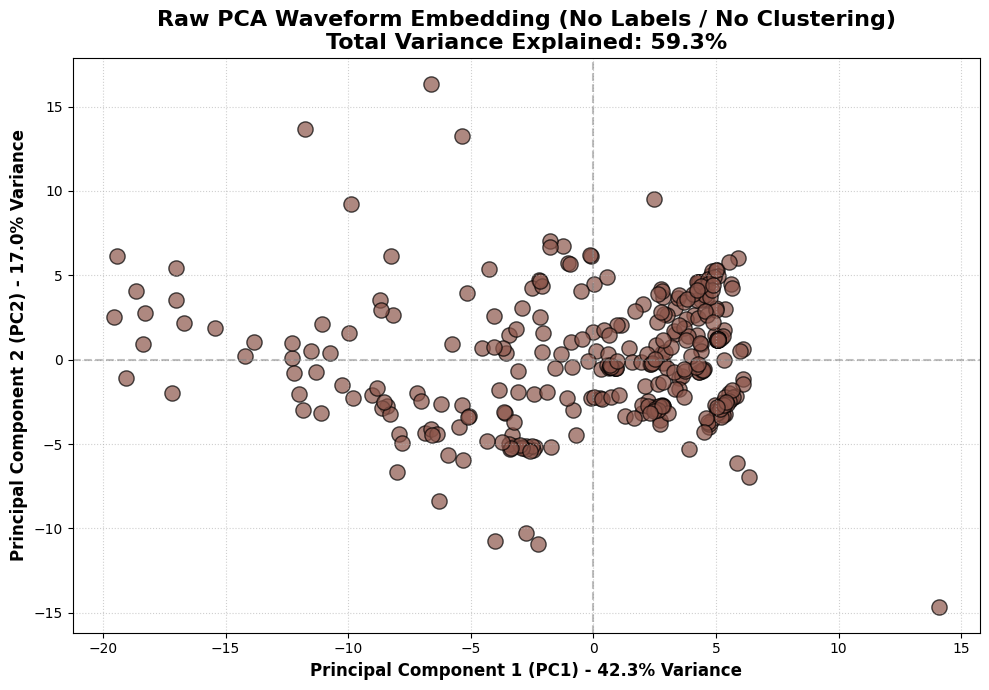

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 1. โหลดข้อมูล
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

# 2. ฟังก์ชัน Scaling
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

# 3. ฟังก์ชันตัดแบ่งลมหายใจ
def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'flow': flow_sig[idx_start:idx_end],
                'pressure': pressure_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end])
            })
    return breaths

# 4. ประมวลผลและสกัดข้อมูล
all_breaths = []
time_step = 0.04
fixed_length = 80 # ความยาวตายตัวสำหรับการทำ PCA

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': np.max(b['flow']),
            'Calculated_Vt_ml': calc_vt,
            'flow_padded': f_padded
        })

df_feat = pd.DataFrame(all_breaths)

# 5. Isolation Forest กรองเฉพาะความผิดปกติ
X_iso = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.15, random_state=42)
df_feat['Anomaly_Status'] = iso.fit_predict(X_iso)
anomalies_df = df_feat[df_feat['Anomaly_Status'] == -1].copy().reset_index(drop=True)

# 6. PCA (ไม่มี K-Means, ไม่มี Label)
X_waveforms = np.stack(anomalies_df['flow_padded'].values)
X_waveforms_scaled = StandardScaler().fit_transform(X_waveforms)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_waveforms_scaled)

anomalies_df['PC1'] = X_pca[:, 0]
anomalies_df['PC2'] = X_pca[:, 1]

# วาดกราฟ
plt.figure(figsize=(10, 7))

# พล็อตจุดสีเดียวทั้งหมด เพื่อโชว์การกระจายตัวตามธรรมชาติ
plt.scatter(anomalies_df['PC1'], anomalies_df['PC2'], color='#8c564b', s=120, alpha=0.7, edgecolors='black')

var_ratio = pca.explained_variance_ratio_
plt.title(f'Raw PCA Waveform Embedding (No Labels / No Clustering)\nTotal Variance Explained: {(var_ratio[0]+var_ratio[1])*100:.1f}%', fontsize=16, fontweight='bold')
plt.xlabel(f'Principal Component 1 (PC1) - {var_ratio[0]*100:.1f}% Variance', fontsize=12, fontweight='bold')
plt.ylabel(f'Principal Component 2 (PC2) - {var_ratio[1]*100:.1f}% Variance', fontsize=12, fontweight='bold')

plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig('pca_pure_scatter.png')
print("Pure PCA Plot Generated!")

Saved raw PCA plot successfully!


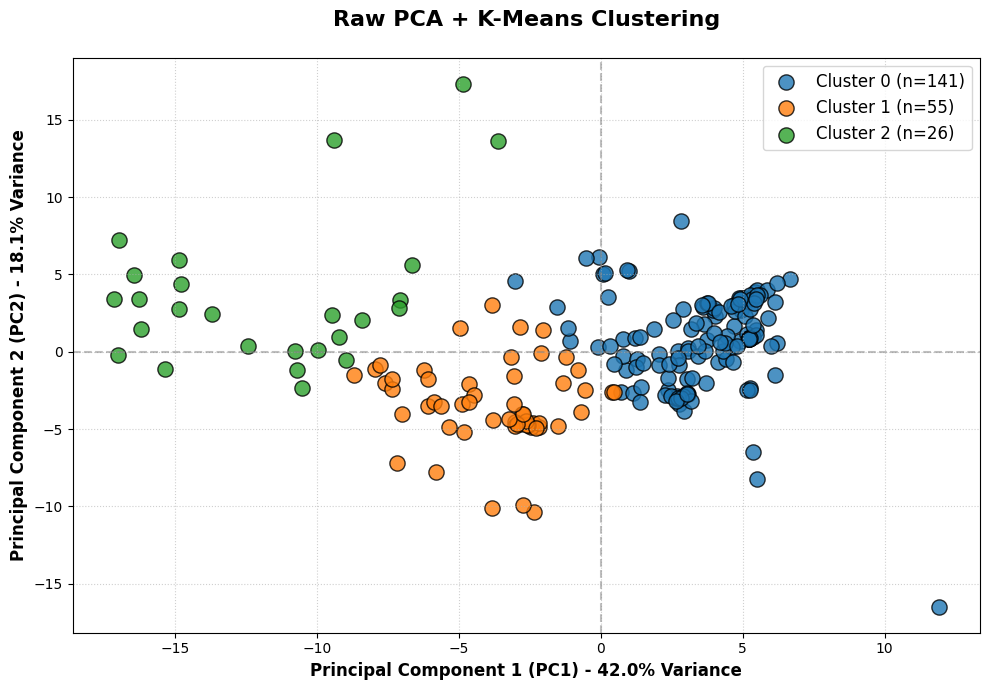

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 1. โหลดข้อมูล
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'flow': flow_sig[idx_start:idx_end],
                'pressure': pressure_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04
fixed_length = 80 

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': np.max(b['flow']),
            'Calculated_Vt_ml': calc_vt,
            'flow_padded': f_padded
        })

df_feat = pd.DataFrame(all_breaths)

# --- ขั้นตอนที่ 1: ตรวจจับ Anomaly ด้วย Isolation Forest ---
X_iso = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly_Status'] = iso.fit_predict(X_iso)

# คัดมาเฉพาะข้อมูลที่ผิดปกติ
anomalies_df = df_feat[df_feat['Anomaly_Status'] == -1].copy().reset_index(drop=True)

# --- ขั้นตอนที่ 2: ใช้ PCA ลดมิติกราฟ Waveform ลงเหลือ 2 แกน ---
X_waveforms = np.stack(anomalies_df['flow_padded'].values)
X_waveforms_scaled = StandardScaler().fit_transform(X_waveforms)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_waveforms_scaled)

anomalies_df['PC1'] = X_pca[:, 0]
anomalies_df['PC2'] = X_pca[:, 1]

# --- ขั้นตอนที่ 3: จัดกลุ่ม Sub-typing บนพื้นที่ PCA (ด้วย K-Means) ---
kmeans_pca = KMeans(n_clusters=3, random_state=42)
anomalies_df['PCA_Cluster'] = kmeans_pca.fit_predict(X_pca)

# --- วาดกราฟ 2D PCA Space แบบไม่มี Clinical Rules (โชว์ดิบๆ) ---
plt.figure(figsize=(10, 7))

# ใช้สีพื้นฐานสำหรับ Cluster 0, 1, 2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for cluster_id in sorted(anomalies_df['PCA_Cluster'].unique()):
    subset = anomalies_df[anomalies_df['PCA_Cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], c=colors[cluster_id], s=120, alpha=0.8, edgecolors='black', label=f"Cluster {cluster_id} (n={len(subset)})")

var_ratio = pca.explained_variance_ratio_
plt.title(f'Raw PCA + K-Means Clustering\n', fontsize=16, fontweight='bold')
plt.xlabel(f'Principal Component 1 (PC1) - {var_ratio[0]*100:.1f}% Variance', fontsize=12, fontweight='bold')
plt.ylabel(f'Principal Component 2 (PC2) - {var_ratio[1]*100:.1f}% Variance', fontsize=12, fontweight='bold')

plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig('pca_raw_clustering.png')
print("Saved raw PCA plot successfully!")

Running PCA on Time-Series Flow Waveforms...
PCA Execution and Plotting Complete!


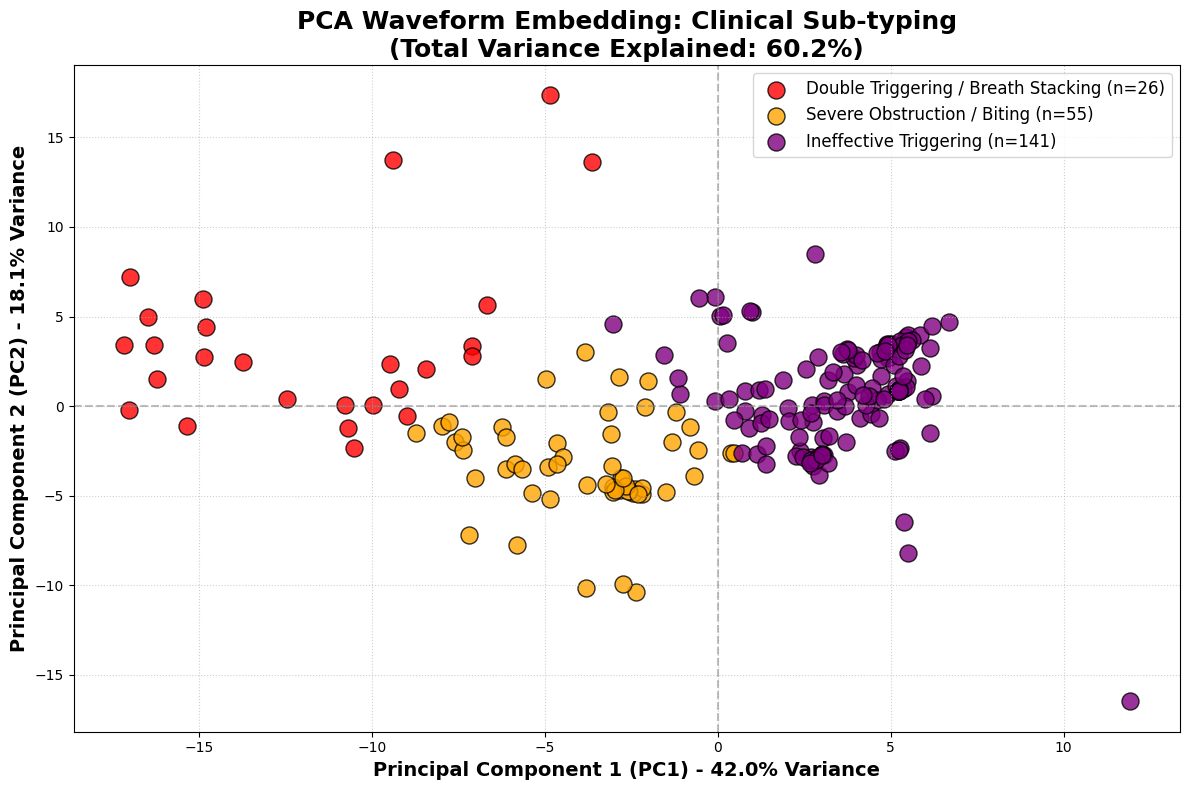

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 1. โหลดข้อมูล (ใช้ 150 แถวเพื่อให้ประมวลผลเร็ว)
df = pd.read_csv('mv_waveform_2026-02-05.csv')

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'flow': flow_sig[idx_start:idx_end],
                'pressure': pressure_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04
fixed_length = 80 # ความยาวตายตัวสำหรับการทำ PCA บน Waveform โดยตรง

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # ตัดกราฟ Flow ให้ยาว 80 จุดเท่ากัน เพื่อเอาไปป้อนให้ PCA ถอดรหัสรูปทรง
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': np.max(b['flow']),
            'Calculated_Vt_ml': calc_vt,
            'flow_padded': f_padded
        })

df_feat = pd.DataFrame(all_breaths)

# --- ขั้นตอนที่ 1: ตรวจจับ Anomaly ด้วย Isolation Forest ---
X_iso = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly_Status'] = iso.fit_predict(X_iso)

# คัดมาเฉพาะข้อมูลที่ผิดปกติ
anomalies_df = df_feat[df_feat['Anomaly_Status'] == -1].copy().reset_index(drop=True)

# --- ขั้นตอนที่ 2: ใช้ PCA ลดมิติกราฟ Waveform ลงเหลือ 2 แกน ---
print("Running PCA on Time-Series Flow Waveforms...")
# ดึงกราฟ Flow (80 มิติ) มาทำ Standard Scale
X_waveforms = np.stack(anomalies_df['flow_padded'].values)
X_waveforms_scaled = StandardScaler().fit_transform(X_waveforms)

# ประยุกต์ใช้ PCA ลดมิติจาก 80 แกน (เวลา) เหลือ 2 แกนหลัก
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_waveforms_scaled)

# เอาพิกัด PC1 และ PC2 ใส่กลับลงไปใน DataFrame
anomalies_df['PC1'] = X_pca[:, 0]
anomalies_df['PC2'] = X_pca[:, 1]

# --- ขั้นตอนที่ 3: จัดกลุ่ม Sub-typing บนพื้นที่ PCA (ด้วย K-Means) ---
kmeans_pca = KMeans(n_clusters=3, random_state=42)
anomalies_df['PCA_Cluster'] = kmeans_pca.fit_predict(X_pca)

# ตั้งชื่อ Label ให้แพทย์อ่านเข้าใจ
def assign_labels(df, cluster_col):
    means = df.groupby(cluster_col)[['PIP', 'Calculated_Vt_ml']].mean()
    dt_cluster = means['Calculated_Vt_ml'].idxmax()
    so_cluster = means.drop(dt_cluster)['PIP'].idxmax()
    it_cluster = means.drop([dt_cluster, so_cluster]).index[0]
    
    label_map = {
        dt_cluster: 'Double Triggering / Breath Stacking',
        so_cluster: 'Severe Obstruction / Biting',
        it_cluster: 'Ineffective Triggering'
    }
    return df[cluster_col].map(label_map)

anomalies_df['Clinical_Label'] = assign_labels(anomalies_df, 'PCA_Cluster')

# --- วาดกราฟ 2D PCA Space ---
plt.figure(figsize=(12, 8))

color_map = {
    'Double Triggering / Breath Stacking': 'red',
    'Severe Obstruction / Biting': 'orange',
    'Ineffective Triggering': 'purple'
}

for label, color in color_map.items():
    subset = anomalies_df[anomalies_df['Clinical_Label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, s=150, alpha=0.8, edgecolors='black', label=f"{label} (n={len(subset)})")

# ใส่ข้อมูล Explained Variance Ratio เพื่อให้ดูโปรเฟสชันนัล
var_ratio = pca.explained_variance_ratio_
plt.title(f'PCA Waveform Embedding: Clinical Sub-typing\n(Total Variance Explained: {(var_ratio[0]+var_ratio[1])*100:.1f}%)', fontsize=18, fontweight='bold')
plt.xlabel(f'Principal Component 1 (PC1) - {var_ratio[0]*100:.1f}% Variance', fontsize=14, fontweight='bold')
plt.ylabel(f'Principal Component 2 (PC2) - {var_ratio[1]*100:.1f}% Variance', fontsize=14, fontweight='bold')

plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig('pca_subtyping_scatter.png')
print("PCA Execution and Plotting Complete!")

Running Phase 1: Isolation Forest Anomaly Detection...
Running Phase 2: DTW Clustering on Anomalies...
Execution Complete!


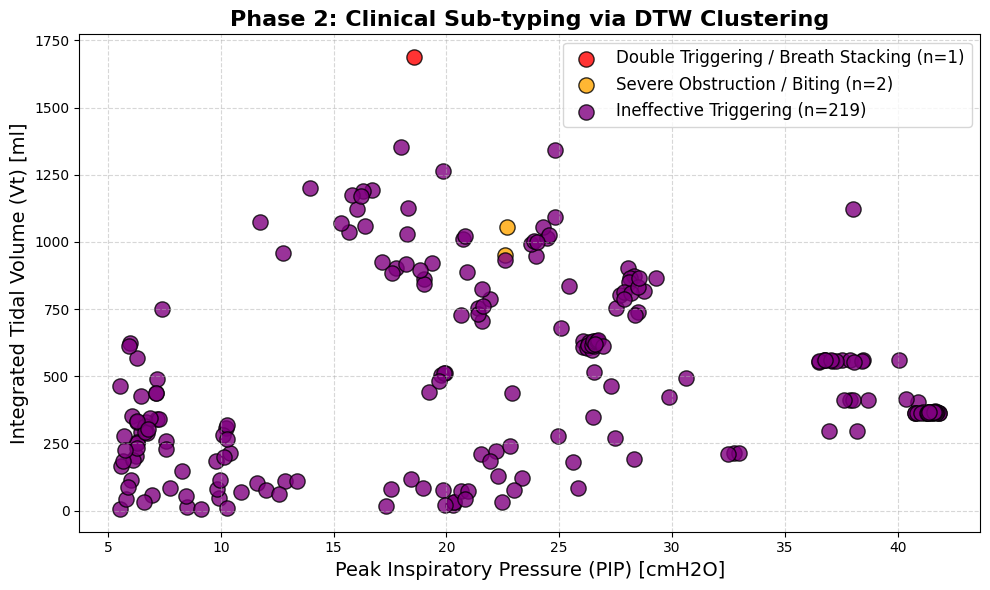

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')

# 1
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04
fixed_length = 80 # 3.2 วินาที (80 จุด)

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # Padded array
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': np.max(b['flow']),
            'Calculated_Vt_ml': calc_vt,
            'flow_padded': f_padded
        })

df_feat = pd.DataFrame(all_breaths)

# --- ขั้นตอนที่ 1: การตรวจจับความผิดปกติภาพรวมด้วย Isolation Forest ---
print("Running Phase 1: Isolation Forest Anomaly Detection...")
X_iso = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly_Status'] = iso.fit_predict(X_iso)

# วาดกราฟภาพรวม (Isolation Forest Scatter Plot)
plt.figure(figsize=(10, 6))
colors = ['red' if x == -1 else 'blue' for x in df_feat['Anomaly_Status']]
plt.scatter(df_feat['PIP'], df_feat['Calculated_Vt_ml'], c=colors, s=80, alpha=0.7, edgecolors='black')
plt.title(f'Isolation Forest Anomaly Detection across {len(df_feat)} Breaths', fontsize=16, fontweight='bold')
plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=14)
plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Normal (1) [n={sum(df_feat["Anomaly_Status"]==1)}]', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f'Anomaly (-1) [n={sum(df_feat["Anomaly_Status"]==-1)}]', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper left')
plt.tight_layout()
plt.savefig('isolation_forest_overall.png')
plt.close()


# --- ขั้นตอนที่ 2: Clinical Sub-typing ด้วย DTW เฉพาะกลุ่ม Anomaly ---
print("Running Phase 2: DTW Clustering on Anomalies...")
anomalies_df = df_feat[df_feat['Anomaly_Status'] == -1].copy().reset_index(drop=True)

# 2.1 คำนวณ DTW Matrix (Dynamic Time Warping)
def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

N_ano = len(anomalies_df)
dtw_dist_matrix = np.zeros((N_ano, N_ano))
flows = np.stack(anomalies_df['flow_padded'].values)

for i in range(N_ano):
    for j in range(i+1, N_ano):
        dist = dtw_distance(flows[i], flows[j])
        dtw_dist_matrix[i, j] = dist
        dtw_dist_matrix[j, i] = dist

# 2.2 จัดกลุ่มและตั้งชื่อ Label
agglo = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
anomalies_df['DTW_Cluster'] = agglo.fit_predict(dtw_dist_matrix)

def assign_labels(df, cluster_col):
    means = df.groupby(cluster_col)[['PIP', 'Calculated_Vt_ml']].mean()
    dt_cluster = means['Calculated_Vt_ml'].idxmax()
    so_cluster = means.drop(dt_cluster)['PIP'].idxmax()
    it_cluster = means.drop([dt_cluster, so_cluster]).index[0]
    
    label_map = {
        dt_cluster: 'Double Triggering / Breath Stacking',
        so_cluster: 'Severe Obstruction / Biting',
        it_cluster: 'Ineffective Triggering'
    }
    return df[cluster_col].map(label_map)

anomalies_df['DTW_Label'] = assign_labels(anomalies_df, 'DTW_Cluster')

# 2.3 วาดกราฟแสดงการจัดกลุ่มย่อย (Clinical Sub-typing Plot)
plt.figure(figsize=(10, 6))
color_map = {
    'Double Triggering / Breath Stacking': 'red',
    'Severe Obstruction / Biting': 'orange',
    'Ineffective Triggering': 'purple'
}

for label, color in color_map.items():
    subset = anomalies_df[anomalies_df['DTW_Label'] == label]
    plt.scatter(subset['PIP'], subset['Calculated_Vt_ml'], c=color, s=120, alpha=0.8, edgecolors='black', label=f"{label} (n={len(subset)})")

plt.title('Phase 2: Clinical Sub-typing via DTW Clustering', fontsize=16, fontweight='bold')
plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=14)
plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('dtw_subtyping_scatter.png')
print("Execution Complete!")

Phase 1: Overall Anomaly Detection using 1D-CNN Autoencoder...
Phase 2: Clinical Sub-typing on Anomalies...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Complete!


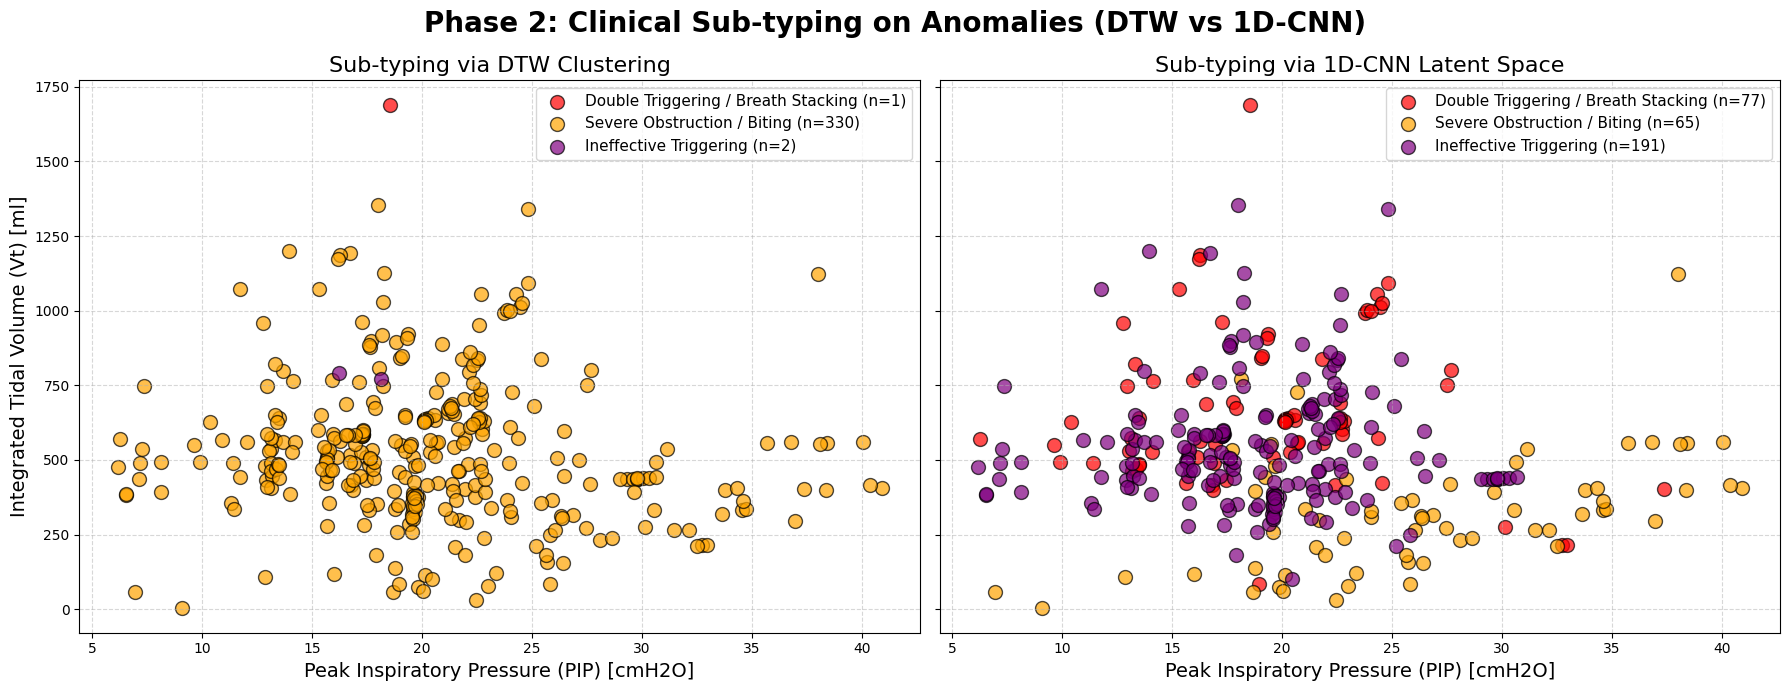

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
import warnings
warnings.filterwarnings('ignore')

# 1. 
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04
fixed_length = 80 # 3.2 วินาที (80 จุด)

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # Padded array
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        p_seg = b['pressure']
        if len(p_seg) > fixed_length:
            p_padded = p_seg[:fixed_length]
        else:
            p_padded = np.pad(p_seg, (0, fixed_length - len(p_seg)), 'constant')
            
        all_breaths.append({
            'PIP': b['pip'],
            'Calculated_Vt_ml': calc_vt,
            'flow_padded': f_padded,
            'pressure_padded': p_padded
        })

df_feat = pd.DataFrame(all_breaths)

# --- ตอนที่ 1: ใช้ 1D-CNN (Autoencoder) กรองความผิดปกติแบบภาพรวม ---
print("Phase 1: Overall Anomaly Detection using 1D-CNN Autoencoder...")
X_cnn_all = np.stack(df_feat['flow_padded'].values)
X_cnn_all_scaled = StandardScaler().fit_transform(X_cnn_all)

model_iso = Sequential([
    Input(shape=(fixed_length,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(fixed_length, activation='linear')
])
model_iso.compile(optimizer='adam', loss='mse')
model_iso.fit(X_cnn_all_scaled, X_cnn_all_scaled, epochs=20, batch_size=16, verbose=0)

X_pred_all = model_iso.predict(X_cnn_all_scaled, verbose=0)
mse_all = np.mean(np.power(X_cnn_all_scaled - X_pred_all, 2), axis=1)

# ให้ 15% ที่มี Error สูงสุด เป็น Anomaly
threshold_iso = np.percentile(mse_all, 85)
df_feat['Anomaly_CNN'] = [-1 if e > threshold_iso else 1 for e in mse_all]

# วาดภาพรวม Normal vs Anomaly (เหมือน IsoForest เดิม)
plt.figure(figsize=(12, 7))
colors = ['red' if x == -1 else 'blue' for x in df_feat['Anomaly_CNN']]
plt.scatter(df_feat['PIP'], df_feat['Calculated_Vt_ml'], c=colors, s=50, alpha=0.6, edgecolors='black')
plt.title(f'Phase 1: Overall Anomaly Detection (1D-CNN Autoencoder) across {len(df_feat)} Breaths', fontsize=16, fontweight='bold')
plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=12)
plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Normal (1) [n={sum(df_feat["Anomaly_CNN"]==1)}]', markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label=f'Anomaly (-1) [n={sum(df_feat["Anomaly_CNN"]==-1)}]', markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper left')
plt.savefig('phase1_overall_cnn_anomaly.png')
plt.close()


# --- ตอนที่ 2: Clinical Sub-typing (DTW และ 1D-CNN Latent Space) เฉพาะกลุ่ม Anomaly ---
print("Phase 2: Clinical Sub-typing on Anomalies...")
anomalies_df = df_feat[df_feat['Anomaly_CNN'] == -1].copy().reset_index(drop=True)

# ฟังก์ชันกำหนด Label อิงจากข้อกำหนดทางการแพทย์ (ทฤษฎี)
def assign_labels(df, cluster_col):
    means = df.groupby(cluster_col)[['PIP', 'Calculated_Vt_ml']].mean()
    
    # 1. กลุ่มที่ Vt เฉลี่ยสูงสุด = Double Triggering
    dt_cluster = means['Calculated_Vt_ml'].idxmax()
    # 2. ในกลุ่มที่เหลือ กลุ่มที่ PIP เฉลี่ยสูงสุด = Severe Obstruction
    so_cluster = means.drop(dt_cluster)['PIP'].idxmax()
    # 3. กลุ่มสุดท้าย = Ineffective Triggering
    it_cluster = means.drop([dt_cluster, so_cluster]).index[0]
    
    label_map = {
        dt_cluster: 'Double Triggering / Breath Stacking',
        so_cluster: 'Severe Obstruction / Biting',
        it_cluster: 'Ineffective Triggering'
    }
    return df[cluster_col].map(label_map)

# == DTW Clustering ==
def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

N_ano = len(anomalies_df)
dtw_dist_matrix = np.zeros((N_ano, N_ano))
flows = np.stack(anomalies_df['flow_padded'].values)

for i in range(N_ano):
    for j in range(i+1, N_ano):
        dist = dtw_distance(flows[i], flows[j])
        dtw_dist_matrix[i, j] = dist
        dtw_dist_matrix[j, i] = dist

agglo = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
anomalies_df['DTW_Cluster'] = agglo.fit_predict(dtw_dist_matrix)
anomalies_df['DTW_Label'] = assign_labels(anomalies_df, 'DTW_Cluster')

# == 1D-CNN (Latent Space Clustering) ==
X_cnn = np.stack([np.stack(anomalies_df['flow_padded'].values), np.stack(anomalies_df['pressure_padded'].values)], axis=-1)
input_shape = (80, 2)

encoder_input = Input(shape=input_shape)
x = Conv1D(16, 3, activation='relu', padding='same')(encoder_input)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x) # (20, 8)
x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(2, 3, activation='linear', padding='same')(x)

autoencoder = Model(encoder_input, decoded)
encoder = Model(encoder_input, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

X_cnn_scaled = np.zeros_like(X_cnn)
for ch in range(2):
    X_cnn_scaled[:, :, ch] = StandardScaler().fit_transform(X_cnn[:, :, ch])

autoencoder.fit(X_cnn_scaled, X_cnn_scaled, epochs=50, batch_size=8, verbose=0)

latent_features = encoder.predict(X_cnn_scaled)
latent_flat = latent_features.reshape((latent_features.shape[0], -1))

kmeans_cnn = KMeans(n_clusters=3, random_state=42)
anomalies_df['CNN_Cluster'] = kmeans_cnn.fit_predict(latent_flat)
anomalies_df['CNN_Label'] = assign_labels(anomalies_df, 'CNN_Cluster')

# --- วาดกราฟแยกประเภท Sub-typing (คล้ายกับกราฟโดยรวม แต่แบ่ง 3 กลุ่ม) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Phase 2: Clinical Sub-typing on Anomalies (DTW vs 1D-CNN)', fontsize=20, fontweight='bold')

color_map = {
    'Double Triggering / Breath Stacking': 'red',
    'Severe Obstruction / Biting': 'orange',
    'Ineffective Triggering': 'purple'
}

# DTW Plot
for label, color in color_map.items():
    subset = anomalies_df[anomalies_df['DTW_Label'] == label]
    axes[0].scatter(subset['PIP'], subset['Calculated_Vt_ml'], c=color, s=100, alpha=0.7, edgecolors='black', label=f"{label} (n={len(subset)})")
axes[0].set_title('Sub-typing via DTW Clustering', fontsize=16)
axes[0].set_xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=14)
axes[0].set_ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(fontsize=11)

# 1D-CNN Plot
for label, color in color_map.items():
    subset = anomalies_df[anomalies_df['CNN_Label'] == label]
    axes[1].scatter(subset['PIP'], subset['Calculated_Vt_ml'], c=color, s=100, alpha=0.7, edgecolors='black', label=f"{label} (n={len(subset)})")
axes[1].set_title('Sub-typing via 1D-CNN Latent Space', fontsize=16)
axes[1].set_xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig('phase2_subtyping_scatter.png')
print("Complete!")

In [16]:
# Export anomalies dataframe to CSV
anomalies_df.to_csv('anomalies_df.csv', index=False)
print('Saved anomalies_df.csv with', len(anomalies_df), 'rows')

Saved anomalies_df.csv with 222 rows


Plotting Completed!


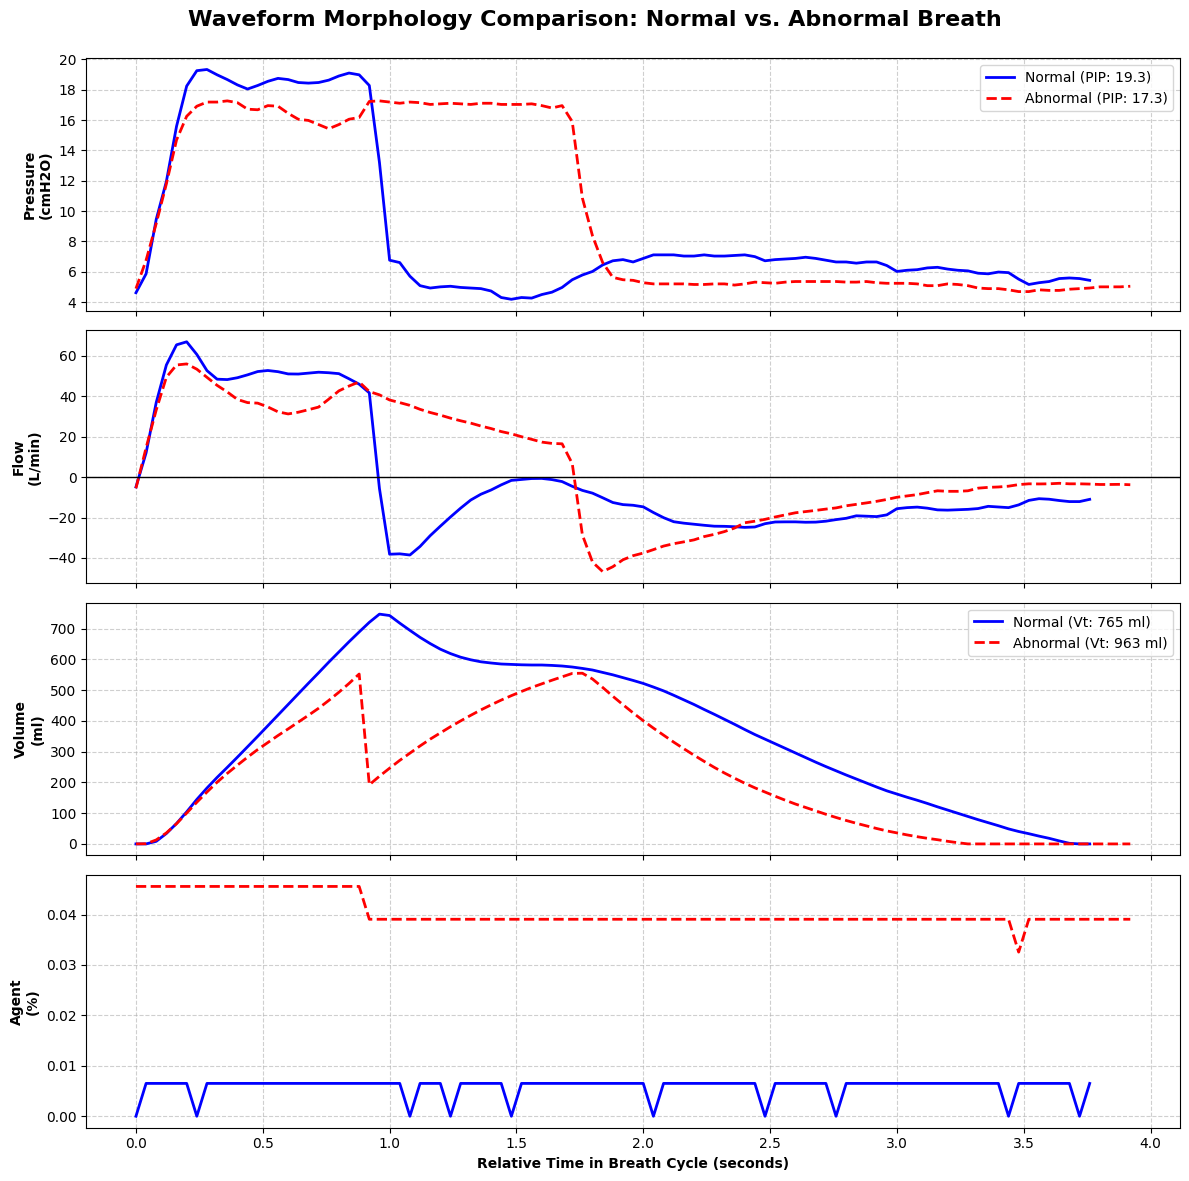

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# โหลดข้อมูล
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM']).head(100)

# ฟังก์ชัน Scaling ตามคู่มือ
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

# ฟังก์ชันตัดแบ่งลมหายใจ
def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

# ประมวลผลข้อมูล
all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]     # ชุดที่ 1: Pressure
        f_hex += b[30:60]    # ชุดที่ 2: Flow
        v_hex += b[60:90]    # ชุดที่ 3: Volume
        a_hex += b[90:120]   # ชุดที่ 4: Agent
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # ปรับ Baseline ของ Volume ดิบให้เริ่มที่ 0 เพื่อให้กราฟดูง่ายขึ้น
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'AdmissionID': row['AdmissionID'],
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt,
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent'],
            'duration': b['duration']
        })

df_feat = pd.DataFrame(all_breaths)

# AI Anomaly Detection
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X)

normal_breaths = df_feat[df_feat['Anomaly'] == 1]
abnormal_breaths = df_feat[df_feat['Anomaly'] == -1]

# เลือกตัวแทนมาพล็อต
rep_norm = normal_breaths.iloc[1] # เลือกลมหายใจปกติ

# เลือกความผิดปกติแบบชัดเจน เช่น Double Triggering (Vt สูงๆ)
rep_abnorm = abnormal_breaths.sort_values('Calculated_Vt_ml', ascending=False).iloc[0]

# --- PLOTTING ---
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
fig.suptitle('Waveform Morphology Comparison: Normal vs. Abnormal Breath', fontsize=16, fontweight='bold')

# สร้างแกนเวลาสัมพัทธ์ (Relative Time) ให้เริ่มจาก 0
t_norm = np.arange(0, len(rep_norm['pressure']) * time_step, time_step)
t_abnorm = np.arange(0, len(rep_abnorm['pressure']) * time_step, time_step)

# 1. Pressure
axes[0].plot(t_norm, rep_norm['pressure'], color='blue', linewidth=2, label=f"Normal (PIP: {rep_norm['PIP']:.1f})")
axes[0].plot(t_abnorm, rep_abnorm['pressure'], color='red', linewidth=2, linestyle='--', label=f"Abnormal (PIP: {rep_abnorm['PIP']:.1f})")
axes[0].set_ylabel('Pressure\n(cmH2O)', fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(loc='upper right')

# 2. Flow
axes[1].plot(t_norm, rep_norm['flow'], color='blue', linewidth=2)
axes[1].plot(t_abnorm, rep_abnorm['flow'], color='red', linewidth=2, linestyle='--')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel('Flow\n(L/min)', fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 3. Volume
axes[2].plot(t_norm, rep_norm['volume'], color='blue', linewidth=2, label=f"Normal (Vt: {rep_norm['Calculated_Vt_ml']:.0f} ml)")
axes[2].plot(t_abnorm, rep_abnorm['volume'], color='red', linewidth=2, linestyle='--', label=f"Abnormal (Vt: {rep_abnorm['Calculated_Vt_ml']:.0f} ml)")
axes[2].set_ylabel('Volume\n(ml)', fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].legend(loc='upper right')

# 4. Anesthetic Agent
axes[3].plot(t_norm, rep_norm['agent'], color='blue', linewidth=2)
axes[3].plot(t_abnorm, rep_abnorm['agent'], color='red', linewidth=2, linestyle='--')
axes[3].set_ylabel('Agent\n(%)', fontweight='bold')
axes[3].set_xlabel('Relative Time in Breath Cycle (seconds)', fontweight='bold')
axes[3].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig('morphology_comparison.png')
print("Plotting Completed!")

Plotting Completed!


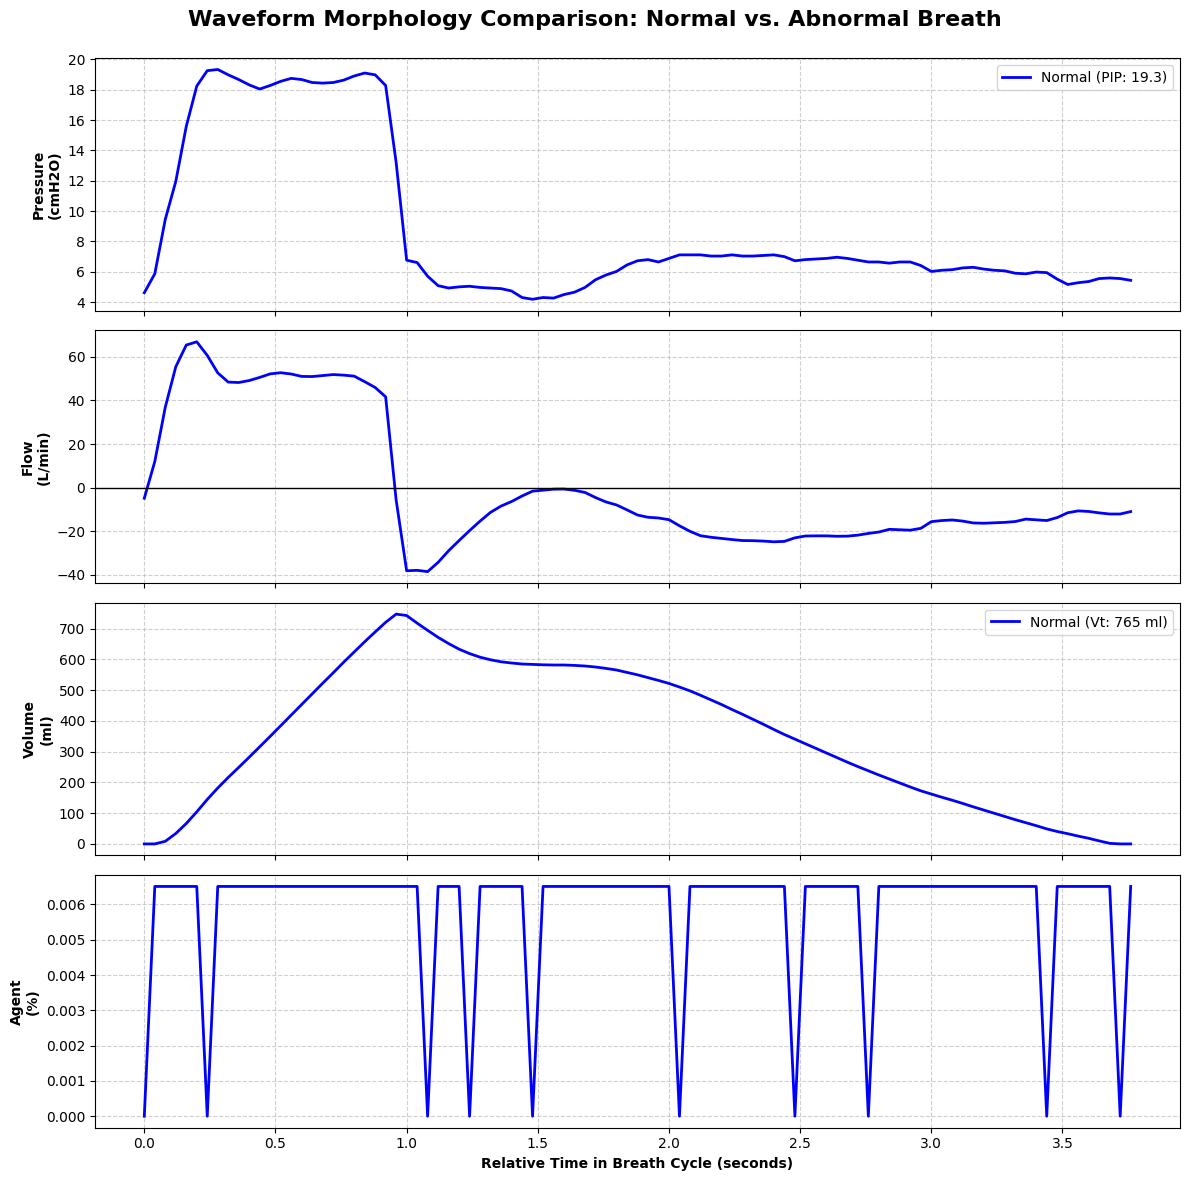

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# โหลดข้อมูล
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM']).head(100)

# ฟังก์ชัน Scaling ตามคู่มือ
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

# ฟังก์ชันตัดแบ่งลมหายใจ
def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

# ประมวลผลข้อมูล
all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]     # ชุดที่ 1: Pressure
        f_hex += b[30:60]    # ชุดที่ 2: Flow
        v_hex += b[60:90]    # ชุดที่ 3: Volume
        a_hex += b[90:120]   # ชุดที่ 4: Agent
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # ปรับ Baseline ของ Volume ดิบให้เริ่มที่ 0 เพื่อให้กราฟดูง่ายขึ้น
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'AdmissionID': row['AdmissionID'],
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt,
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent'],
            'duration': b['duration']
        })

df_feat = pd.DataFrame(all_breaths)

# AI Anomaly Detection
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X)

normal_breaths = df_feat[df_feat['Anomaly'] == 1]
abnormal_breaths = df_feat[df_feat['Anomaly'] == -1]

# เลือกตัวแทนมาพล็อต
rep_norm = normal_breaths.iloc[1] # เลือกลมหายใจปกติ

# เลือกความผิดปกติแบบชัดเจน เช่น Double Triggering (Vt สูงๆ)
rep_abnorm = abnormal_breaths.sort_values('Calculated_Vt_ml', ascending=False).iloc[0]

# --- PLOTTING ---
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
fig.suptitle('Waveform Morphology Comparison: Normal vs. Abnormal Breath', fontsize=16, fontweight='bold')

# สร้างแกนเวลาสัมพัทธ์ (Relative Time) ให้เริ่มจาก 0
t_norm = np.arange(0, len(rep_norm['pressure']) * time_step, time_step)
#t_abnorm = np.arange(0, len(rep_abnorm['pressure']) * time_step, time_step)

# 1. Pressure
axes[0].plot(t_norm, rep_norm['pressure'], color='blue', linewidth=2, label=f"Normal (PIP: {rep_norm['PIP']:.1f})")
#axes[0].plot(t_abnorm, rep_abnorm['pressure'], color='red', linewidth=2, linestyle='--', label=f"Abnormal (PIP: {rep_abnorm['PIP']:.1f})")
axes[0].set_ylabel('Pressure\n(cmH2O)', fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(loc='upper right')

# 2. Flow
axes[1].plot(t_norm, rep_norm['flow'], color='blue', linewidth=2)
#axes[1].plot(t_abnorm, rep_abnorm['flow'], color='red', linewidth=2, linestyle='--')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel('Flow\n(L/min)', fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 3. Volume
axes[2].plot(t_norm, rep_norm['volume'], color='blue', linewidth=2, label=f"Normal (Vt: {rep_norm['Calculated_Vt_ml']:.0f} ml)")
#axes[2].plot(t_abnorm, rep_abnorm['volume'], color='red', linewidth=2, linestyle='--', label=f"Abnormal (Vt: {rep_abnorm['Calculated_Vt_ml']:.0f} ml)")
axes[2].set_ylabel('Volume\n(ml)', fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].legend(loc='upper right')

# 4. Anesthetic Agent
axes[3].plot(t_norm, rep_norm['agent'], color='blue', linewidth=2)
#axes[3].plot(t_abnorm, rep_abnorm['agent'], color='red', linewidth=2, linestyle='--')
axes[3].set_ylabel('Agent\n(%)', fontweight='bold')
axes[3].set_xlabel('Relative Time in Breath Cycle (seconds)', fontweight='bold')
axes[3].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig('morphology_comparison.png')
print("Plotting Completed!")

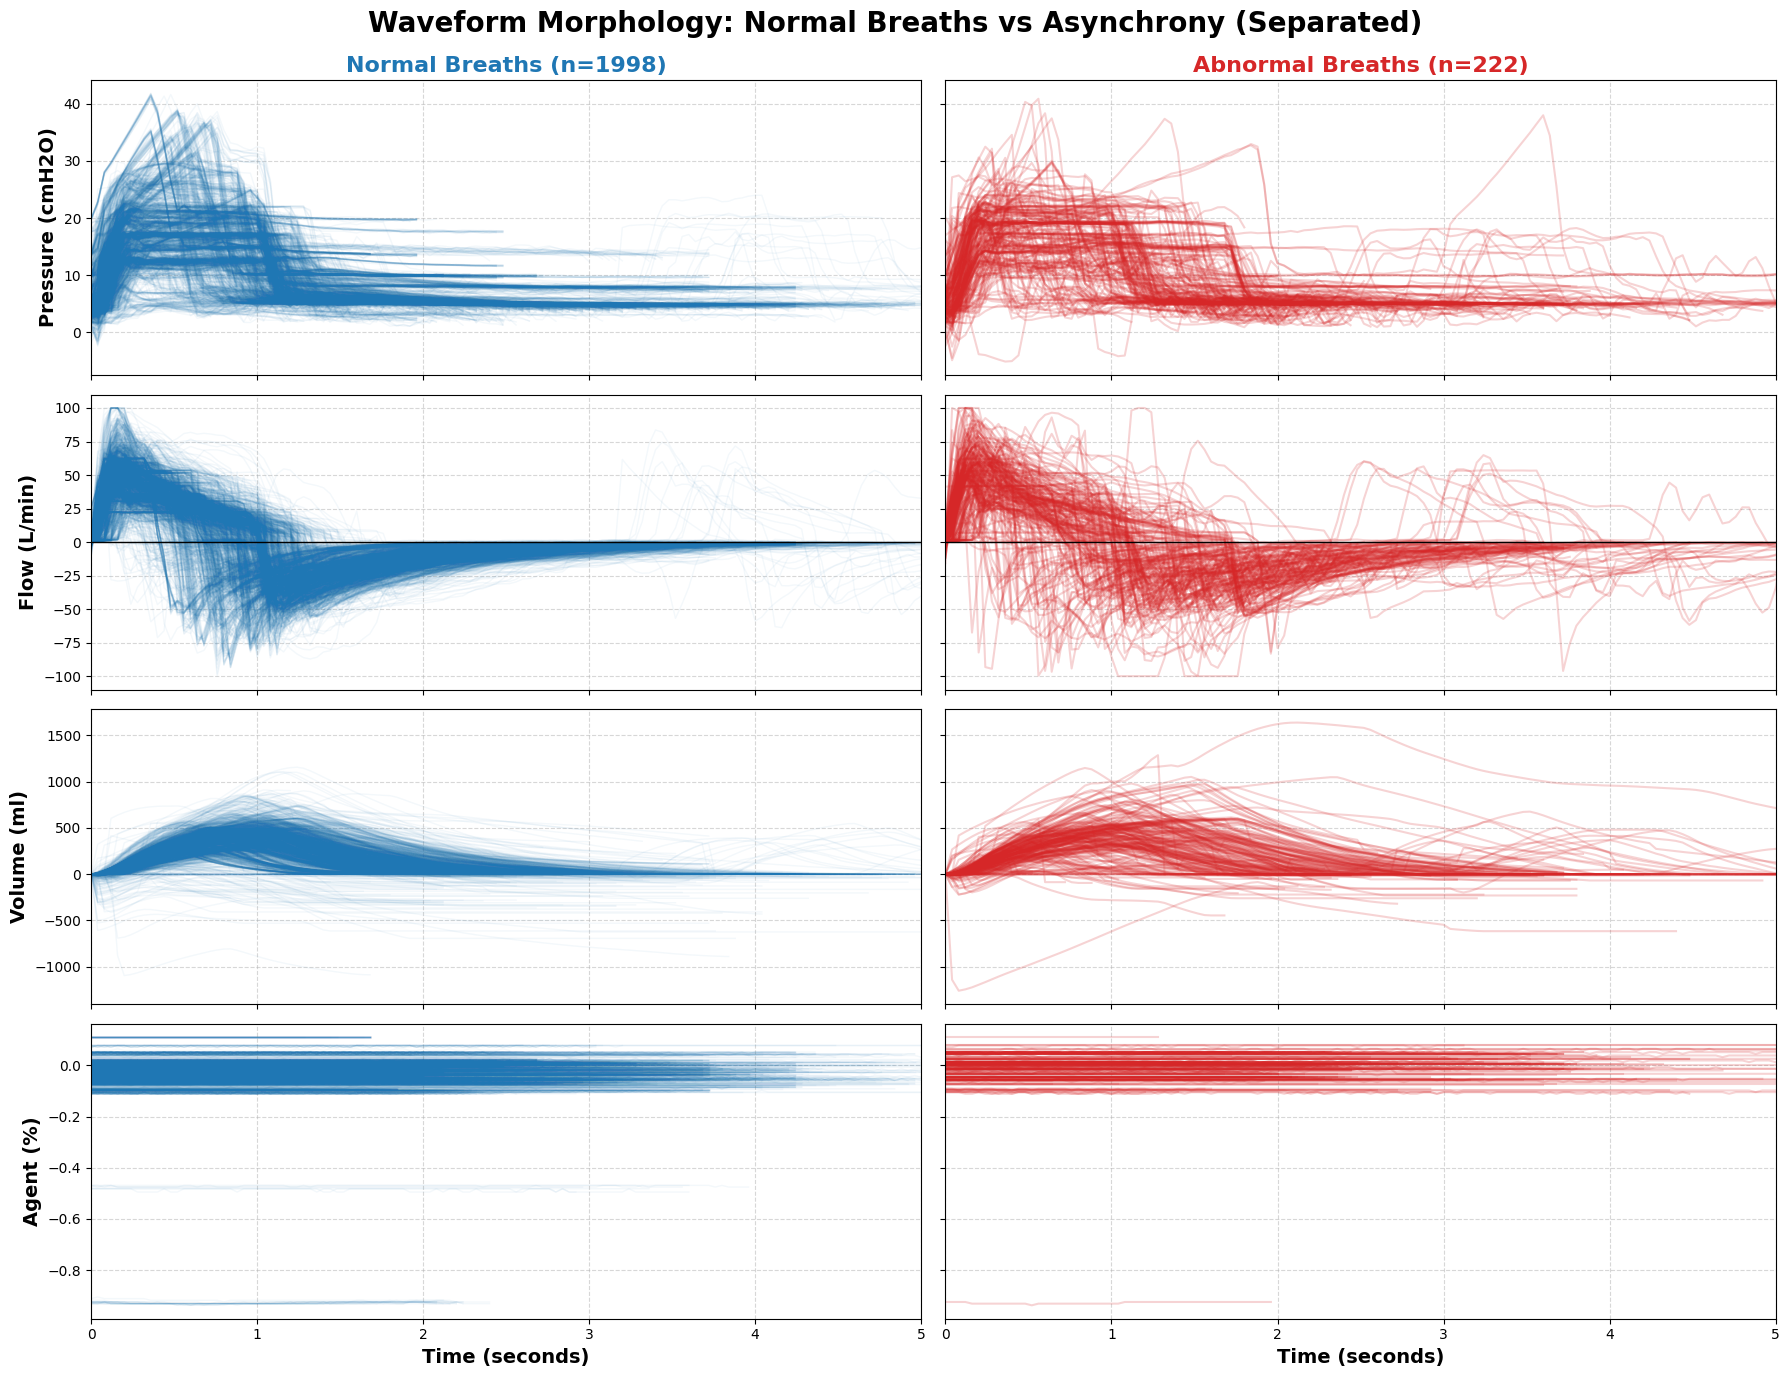

In [ ]:

#วาดกราฟแยก ซ้าย (Normal) - ขวา (Abnormal)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import warnings
warnings.filterwarnings('ignore')

# 1. โหลดข้อมูล (ใช้ 150 แถว)
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM']).head(150)

# 2. ฟังก์ชัน Scaling
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

# 3. ฟังก์ชันตัดแบ่งลมหายใจ
def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end]
            })
    return breaths

# 4. ประมวลผลและสกัดข้อมูล
all_breaths = []
time_step = 0.04
fixed_length = 80 # ความยาว 80 จุด = 3.2 วินาที สำหรับให้ DL เทรน

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]; v_hex += b[60:90]; a_hex += b[90:120]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        # ตัดข้อมูลให้ยาวเท่ากัน (80 จุด) สำหรับโยนเข้า DL
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent'],
            'dl_input_flow': f_padded
        })

df_feat = pd.DataFrame(all_breaths)

# 5. หาความผิดปกติด้วย Deep Learning (Autoencoder)
X_dl = np.stack(df_feat['dl_input_flow'].values)
scaler = StandardScaler()
X_dl_scaled = scaler.fit_transform(X_dl)

# สร้างสถาปัตยกรรม Autoencoder
model = Sequential([
    Input(shape=(fixed_length,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), # Bottleneck 
    Dense(32, activation='relu'),
    Dense(fixed_length, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# ฝึกฝนโมเดลด้วยตัวเอง (Unsupervised)
print("Training Autoencoder...")
model.fit(X_dl_scaled, X_dl_scaled, epochs=20, batch_size=16, verbose=0)

# หา Reconstruction Error (MSE)
X_pred = model.predict(X_dl_scaled, verbose=0)
mse = np.mean(np.power(X_dl_scaled - X_pred, 2), axis=1)

# ตั้งค่าให้ Error เกิน Percentile ที่ 90 ถือเป็นความผิดปกติ
threshold = np.percentile(mse, 90)
df_feat['Anomaly'] = [-1 if e > threshold else 1 for e in mse]

# สร้างกราฟขนาด 4 แถว (เซ็นเซอร์) 2 คอลัมน์ (Normal / Abnormal)
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True, sharey='row')
fig.suptitle('Waveform Morphology: Normal Breaths vs Asynchrony (Separated)', fontsize=20, fontweight='bold')

# กำหนดแกน ซ้าย (0) และ ขวา (1)
col_normal = 0
col_abnormal = 1

for i, row in df_feat.iterrows():
    # จัดการเรื่องความยาว Array (ป้องกัน Error)
    n_pts = len(row['pressure']) if hasattr(row['pressure'], '__len__') else int(row['pressure'])
    t = np.arange(n_pts) * time_step
    
    if row['Anomaly'] == 1:
        # พล็อตลงคอลัมน์ซ้าย (Normal)
        axes[0, col_normal].plot(t, row['pressure'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[1, col_normal].plot(t, row['flow'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[2, col_normal].plot(t, row['volume'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[3, col_normal].plot(t, row['agent'], color='#1f77b4', alpha=0.05, linewidth=1)
    else:
        # พล็อตลงคอลัมน์ขวา (Abnormal)
        axes[0, col_abnormal].plot(t, row['pressure'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[1, col_abnormal].plot(t, row['flow'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[2, col_abnormal].plot(t, row['volume'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[3, col_abnormal].plot(t, row['agent'], color='#d62728', alpha=0.2, linewidth=1.5)

# ตกแต่งกราฟให้สวยงาม
sensor_names = ['Pressure (cmH2O)', 'Flow (L/min)', 'Volume (ml)', 'Agent (%)']

for row_idx in range(4):
    for col_idx in range(2):
        axes[row_idx, col_idx].grid(True, linestyle='--', alpha=0.5)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(sensor_names[row_idx], fontweight='bold', fontsize=14)
        if row_idx == 1: # ใส่เส้นศูนย์ที่แกน Flow
            axes[row_idx, col_idx].axhline(0, color='black', linewidth=1)

axes[0, col_normal].set_title(f'Normal Breaths (n={len(df_feat[df_feat["Anomaly"]==1])})', fontsize=16, color='#1f77b4', fontweight='bold')
axes[0, col_abnormal].set_title(f'Abnormal Breaths (n={len(df_feat[df_feat["Anomaly"]==-1])})', fontsize=16, color='#d62728', fontweight='bold')

axes[3, col_normal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
axes[3, col_abnormal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)

plt.xlim(0, 5) # ซูมดูแค่ 5 วินาทีแรก
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('separated_spaghetti_plot.png')
plt.show()

Side-by-Side ML Plot saved successfully.


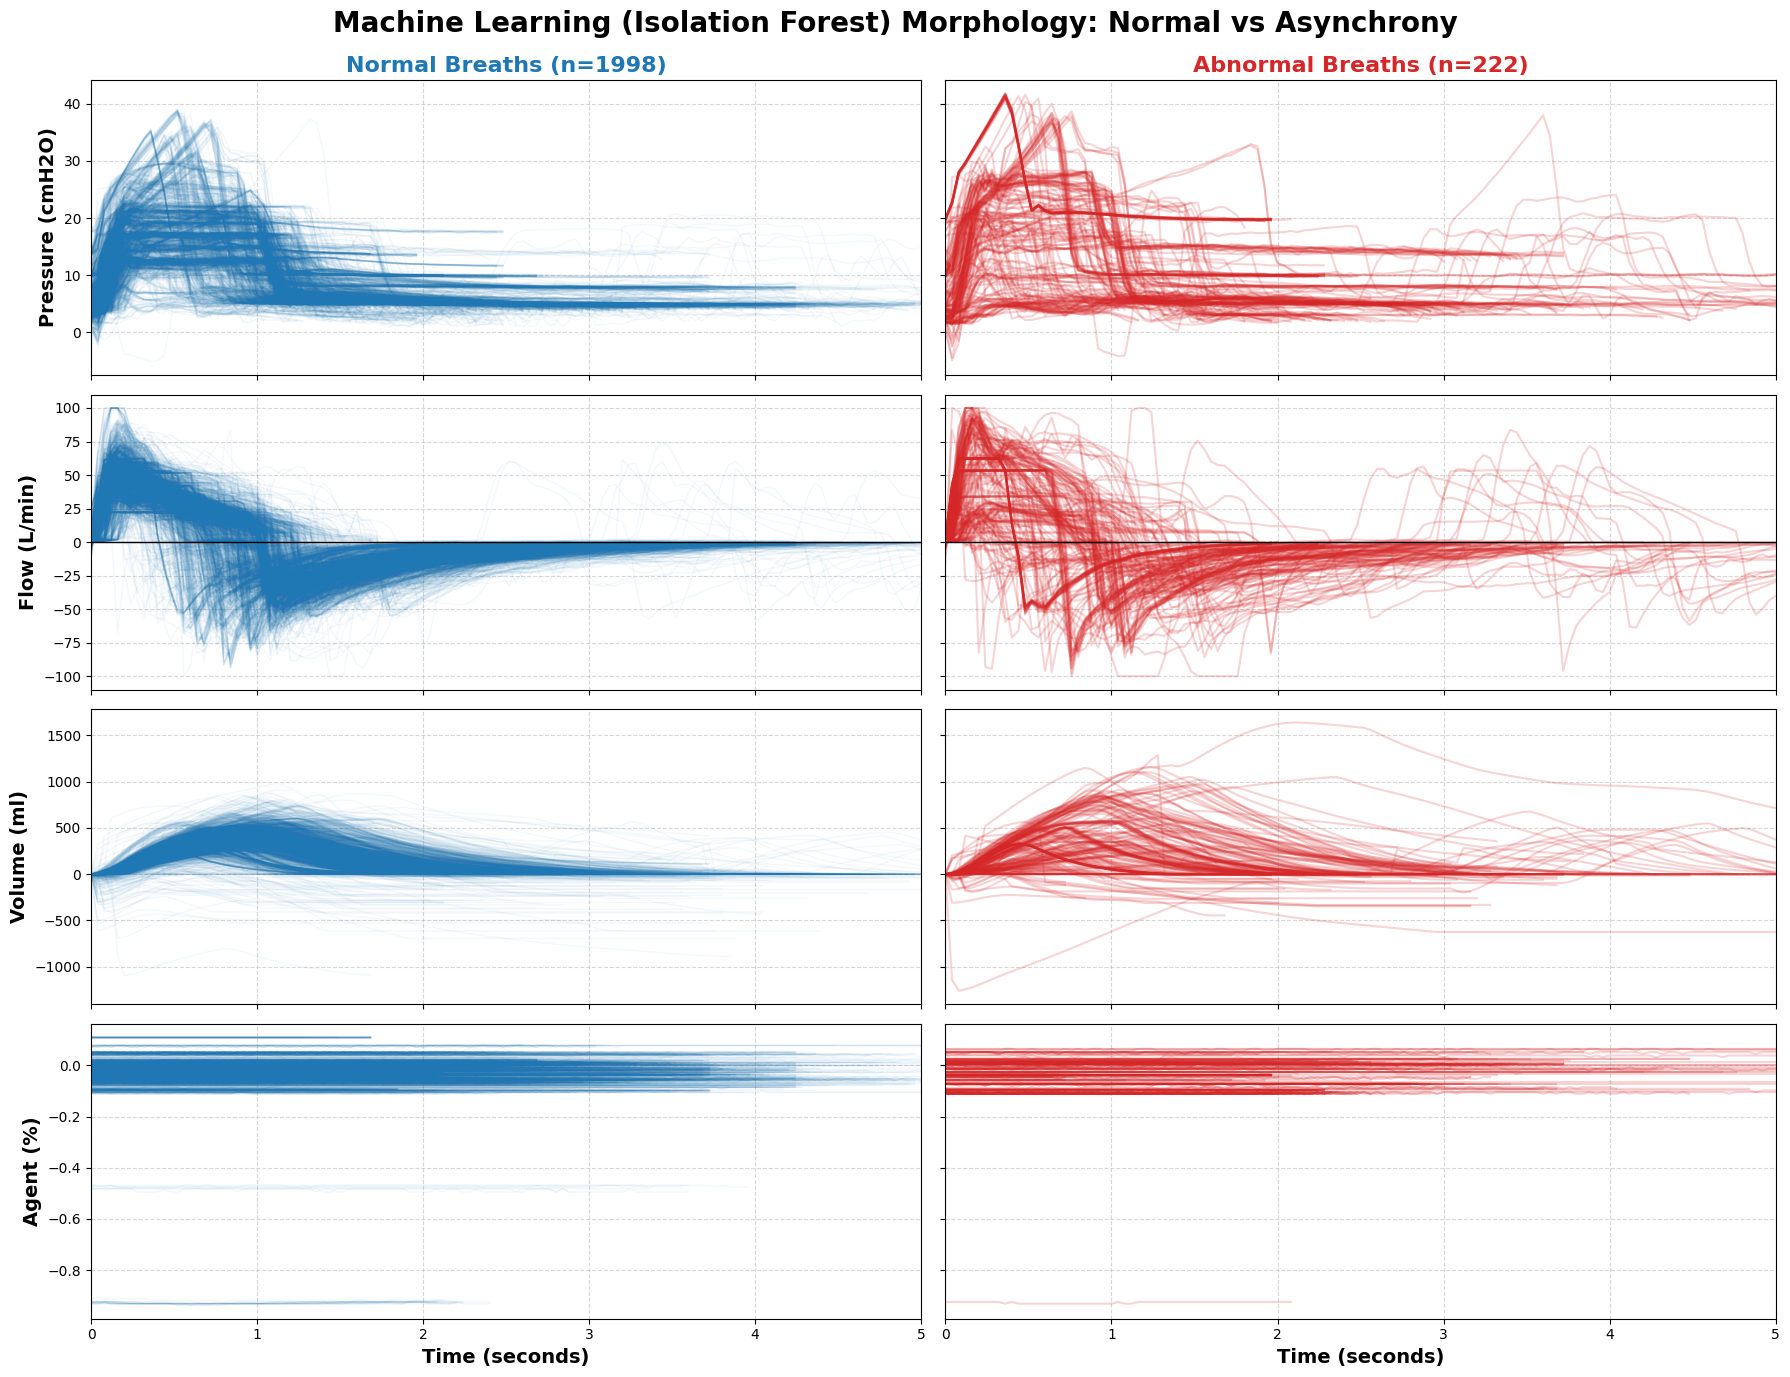

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# 1. 
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]; v_hex += b[60:90]; a_hex += b[90:120]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt,
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent']
        })

df_feat = pd.DataFrame(all_breaths)

# ML Anomaly Detection (Isolation Forest)
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X)

# วาดกราฟแยกซ้าย-ขวา แบบ Side-by-Side สำหรับ ML
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True, sharey='row')
fig.suptitle('Machine Learning (Isolation Forest) Morphology: Normal vs Asynchrony', fontsize=20, fontweight='bold')

col_normal = 0
col_abnormal = 1

for i, row in df_feat.iterrows():
    n_pts = len(row['pressure']) if hasattr(row['pressure'], '__len__') else int(row['pressure'])
    t = np.arange(n_pts) * time_step
    
    if row['Anomaly'] == 1:
        axes[0, col_normal].plot(t, row['pressure'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[1, col_normal].plot(t, row['flow'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[2, col_normal].plot(t, row['volume'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[3, col_normal].plot(t, row['agent'], color='#1f77b4', alpha=0.05, linewidth=1)
    else:
        axes[0, col_abnormal].plot(t, row['pressure'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[1, col_abnormal].plot(t, row['flow'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[2, col_abnormal].plot(t, row['volume'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[3, col_abnormal].plot(t, row['agent'], color='#d62728', alpha=0.2, linewidth=1.5)

sensor_names = ['Pressure (cmH2O)', 'Flow (L/min)', 'Volume (ml)', 'Agent (%)']

for row_idx in range(4):
    for col_idx in range(2):
        axes[row_idx, col_idx].grid(True, linestyle='--', alpha=0.5)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(sensor_names[row_idx], fontweight='bold', fontsize=14)
        if row_idx == 1:
            axes[row_idx, col_idx].axhline(0, color='black', linewidth=1)

axes[0, col_normal].set_title(f'Normal Breaths (n={len(df_feat[df_feat["Anomaly"]==1])})', fontsize=16, color='#1f77b4', fontweight='bold')
axes[0, col_abnormal].set_title(f'Abnormal Breaths (n={len(df_feat[df_feat["Anomaly"]==-1])})', fontsize=16, color='#d62728', fontweight='bold')

axes[3, col_normal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
axes[3, col_abnormal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)

plt.xlim(0, 5)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('ml_separated_spaghetti_plot.png')
print("Side-by-Side ML Plot saved successfully.")

Side-by-Side ML Plot saved successfully.


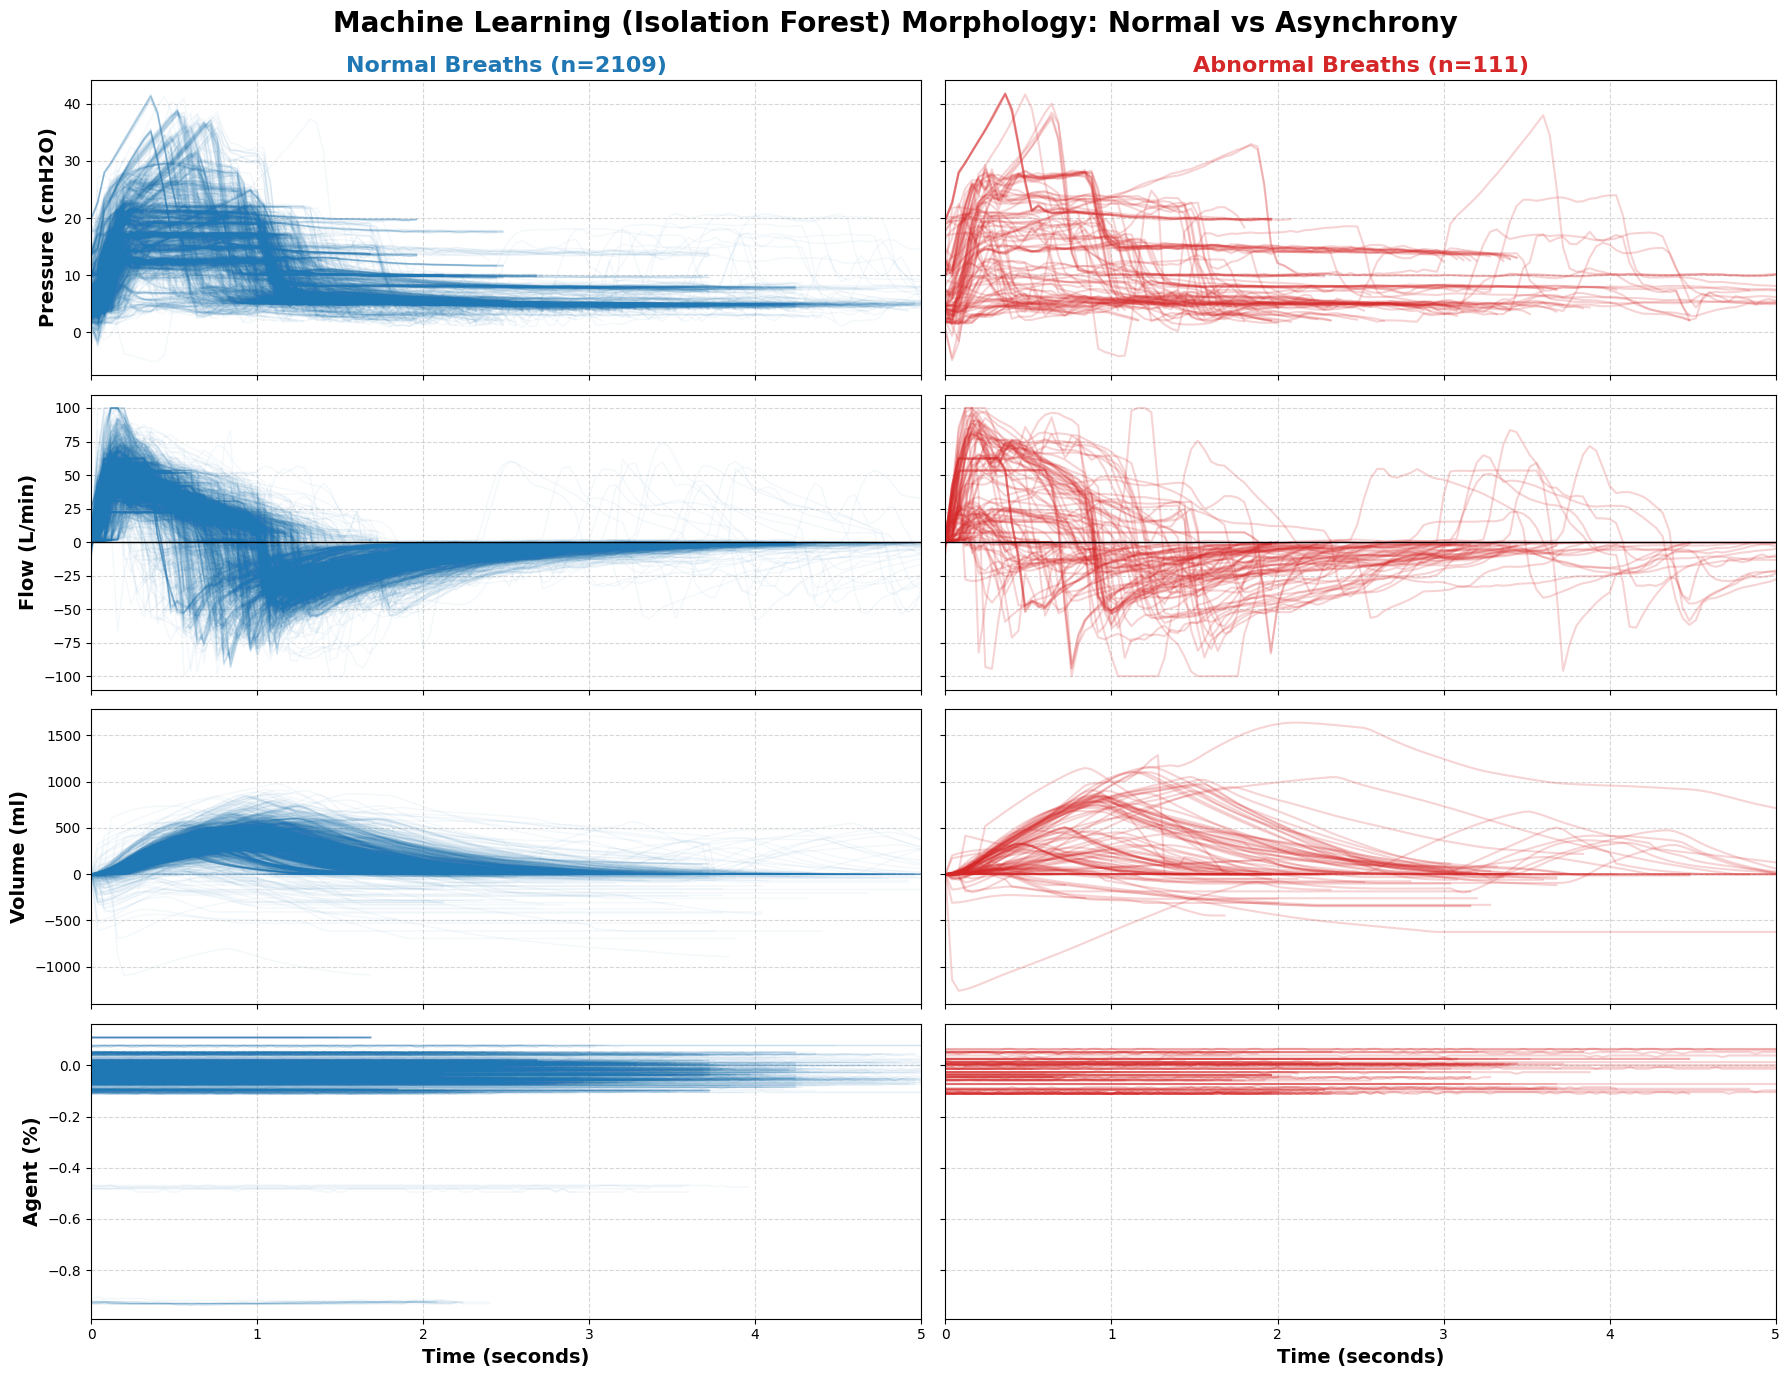

In [ ]:
#0.05
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# 1. 
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]; v_hex += b[60:90]; a_hex += b[90:120]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt,
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent']
        })

df_feat = pd.DataFrame(all_breaths)

# ML Anomaly Detection (Isolation Forest)
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.05, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X)

# วาดกราฟแยกซ้าย-ขวา แบบ Side-by-Side สำหรับ ML
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True, sharey='row')
fig.suptitle('Machine Learning (Isolation Forest) Morphology: Normal vs Asynchrony', fontsize=20, fontweight='bold')

col_normal = 0
col_abnormal = 1

for i, row in df_feat.iterrows():
    n_pts = len(row['pressure']) if hasattr(row['pressure'], '__len__') else int(row['pressure'])
    t = np.arange(n_pts) * time_step
    
    if row['Anomaly'] == 1:
        axes[0, col_normal].plot(t, row['pressure'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[1, col_normal].plot(t, row['flow'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[2, col_normal].plot(t, row['volume'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[3, col_normal].plot(t, row['agent'], color='#1f77b4', alpha=0.05, linewidth=1)
    else:
        axes[0, col_abnormal].plot(t, row['pressure'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[1, col_abnormal].plot(t, row['flow'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[2, col_abnormal].plot(t, row['volume'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[3, col_abnormal].plot(t, row['agent'], color='#d62728', alpha=0.2, linewidth=1.5)

sensor_names = ['Pressure (cmH2O)', 'Flow (L/min)', 'Volume (ml)', 'Agent (%)']

for row_idx in range(4):
    for col_idx in range(2):
        axes[row_idx, col_idx].grid(True, linestyle='--', alpha=0.5)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(sensor_names[row_idx], fontweight='bold', fontsize=14)
        if row_idx == 1:
            axes[row_idx, col_idx].axhline(0, color='black', linewidth=1)

axes[0, col_normal].set_title(f'Normal Breaths (n={len(df_feat[df_feat["Anomaly"]==1])})', fontsize=16, color='#1f77b4', fontweight='bold')
axes[0, col_abnormal].set_title(f'Abnormal Breaths (n={len(df_feat[df_feat["Anomaly"]==-1])})', fontsize=16, color='#d62728', fontweight='bold')

axes[3, col_normal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
axes[3, col_abnormal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)

plt.xlim(0, 5)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
#plt.savefig('ml_separated_spaghetti_plot.png')
print("Side-by-Side ML Plot saved successfully.")

Dashboard Plotted Successfully with spacing fixed!


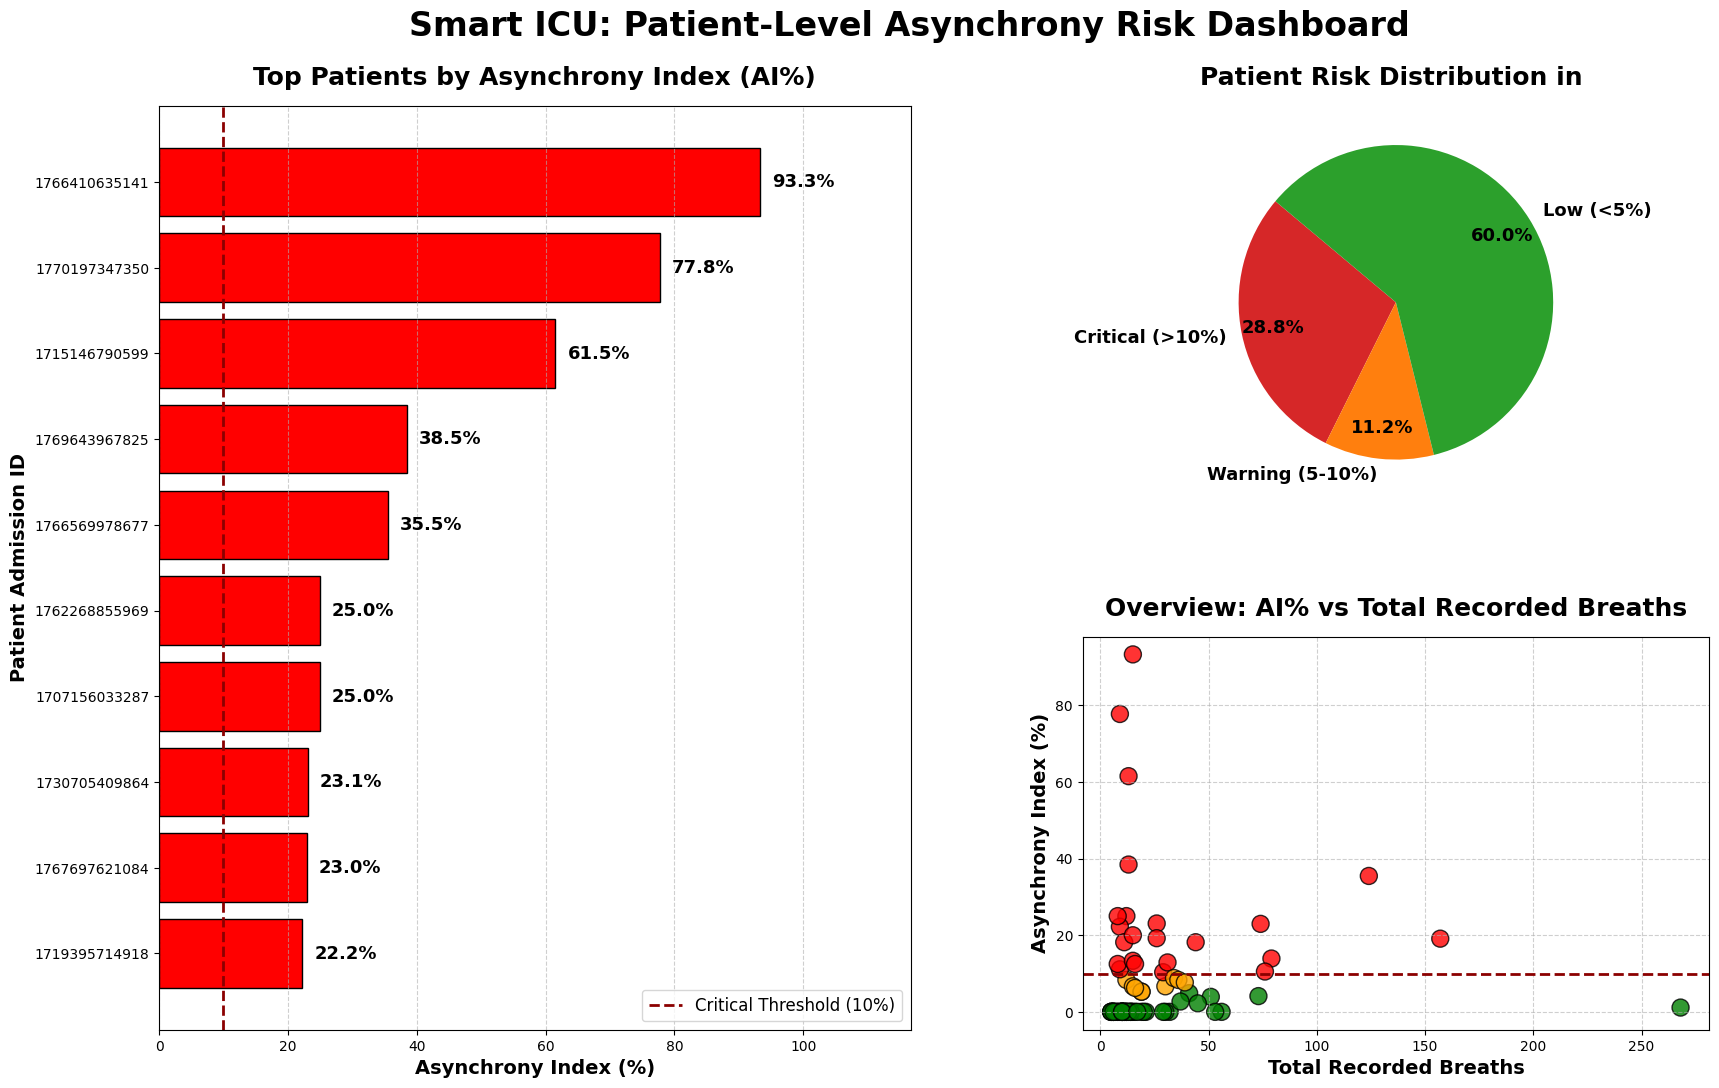

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'flow': flow_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        all_breaths.append({
            'AdmissionID': row['AdmissionID'],
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt
        })

df_feat = pd.DataFrame(all_breaths)

# Isolation Forest
X_iso = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X_iso)
df_feat['Is_Anomaly'] = (df_feat['Anomaly'] == -1).astype(int)

# Dashboard Aggregation
patient_dash = df_feat.groupby('AdmissionID').agg(
    Total_Breaths=('AdmissionID', 'count'),
    Anomalies=('Is_Anomaly', 'sum')
).reset_index()

patient_dash['Asynchrony_Index_%'] = (patient_dash['Anomalies'] / patient_dash['Total_Breaths']) * 100
patient_dash = patient_dash[patient_dash['Total_Breaths'] >= 5]
patient_dash['Risk_Level'] = pd.cut(patient_dash['Asynchrony_Index_%'], 
                                    bins=[-1, 5, 10, 100], 
                                    labels=['Low (<5%)', 'Warning (5-10%)', 'Critical (>10%)'])

# --- Plotting the NEW Dashboard ---
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.2, 1], wspace=0.25, hspace=0.35)
fig.suptitle('Smart ICU: Patient-Level Asynchrony Risk Dashboard', fontsize=24, fontweight='bold', y=0.96)

# 1. Bar Chart (Left Column)
ax1 = fig.add_subplot(gs[:, 0])
top_critical = patient_dash.sort_values('Asynchrony_Index_%', ascending=False).head(10)
top_critical = top_critical.sort_values('Asynchrony_Index_%', ascending=True)

colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in top_critical['Asynchrony_Index_%']]
bars = ax1.barh(top_critical['AdmissionID'].astype(str), top_critical['Asynchrony_Index_%'], color=colors, edgecolor='black')

ax1.set_title('Top Patients by Asynchrony Index (AI%)', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel('Asynchrony Index (%)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Patient Admission ID', fontsize=14, fontweight='bold')
ax1.axvline(10, color='darkred', linestyle='--', linewidth=2, label='Critical Threshold (10%)')
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.legend(fontsize=12, loc='lower right')

# ขยายแกน X เพื่อไม่ให้ตัวเลขเปอร์เซ็นต์ทับเส้นขอบ
max_val = top_critical['Asynchrony_Index_%'].max()
ax1.set_xlim(0, max_val * 1.25) 

# แปะตัวเลขบนแท่ง
for bar in bars:
    ax1.text(bar.get_width() + (max_val * 0.02), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.1f}%', va='center', fontsize=13, fontweight='bold')

# 2. Pie Chart (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
risk_counts = patient_dash['Risk_Level'].value_counts().reindex(['Critical (>10%)', 'Warning (5-10%)', 'Low (<5%)']).fillna(0)
risk_colors = ['#d62728', '#ff7f0e', '#2ca02c']

# กรองเอาเฉพาะอันที่มีค่า > 0 เพื่อไม่ให้ Label ทับกัน
mask = risk_counts > 0
wedges, texts, autotexts = ax2.pie(risk_counts[mask], labels=risk_counts.index[mask], 
                                   colors=[c for i, c in enumerate(risk_colors) if mask.iloc[i]], 
                                   autopct='%1.1f%%', startangle=140, pctdistance=0.8,
                                   textprops=dict(color="black", weight="bold", fontsize=13))
ax2.set_title('Patient Risk Distribution in ', fontsize=18, fontweight='bold', pad=15)

# 3. Scatter Plot (Bottom Right)
ax3 = fig.add_subplot(gs[1, 1])
colors_scatter = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in patient_dash['Asynchrony_Index_%']]
ax3.scatter(patient_dash['Total_Breaths'], patient_dash['Asynchrony_Index_%'], s=150, c=colors_scatter, edgecolors='black', alpha=0.8)
ax3.axhline(10, color='darkred', linestyle='--', linewidth=2, label='Critical Threshold (10%)')

ax3.set_title('Overview: AI% vs Total Recorded Breaths', fontsize=18, fontweight='bold', pad=15)
ax3.set_xlabel('Total Recorded Breaths', fontsize=14, fontweight='bold')
ax3.set_ylabel('Asynchrony Index (%)', fontsize=14, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.savefig('patient_dashboard_fixed.png', bbox_inches='tight', dpi=150)
print("Dashboard Plotted Successfully with spacing fixed!")